# Final project AH2179: Public transport arrival delay prediction

Jiani She, jianis@kth.se <br>
Thomas Bartholomeus Koning, tbkoning@kth.se


In this research we will train multiple machine learning models to predict the arrival delay of busses for SL in Stockholm. For this we have received a dataset from SL with information on all busses and stops along line 4 in the period January 8 to June 30, 2022. 

The code in this document is based on the code provided to us in the exercise materials for the course AH2179 at KTH in the educational year 2023/2024. When sample code from other reference is used, the link to this reference is provided as a comment in the same cell as the code itself. 

## Import packages

In [1]:
#General packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import datetime as dt
from scipy.stats import shapiro
from scipy.stats import kstest
from statsmodels.graphics.gofplots import qqplot
import random
import math

#Sklearn functions:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb

#Ignore warning generated during training models:
import warnings
warnings.filterwarnings('ignore')

## Import data

In [2]:
df = pd.read_csv('Dataset-PT.csv', header = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 31 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Calendar_date                      545103 non-null  int64  
 1   route_id                           545103 non-null  int64  
 2   bus_id                             545103 non-null  int64  
 3   stop_sequence                      545103 non-null  int64  
 4   arrival_delay                      545103 non-null  int64  
 5   dwell_time                         545103 non-null  int64  
 6   travel_time_for_previous_section   545103 non-null  int64  
 7   scheduled_travel_time              545103 non-null  int64  
 8   upstream_stop_delay                545103 non-null  int64  
 9   origin_delay                       545103 non-null  int64  
 10  previous_bus_delay                 545103 non-null  int64  
 11  previous_trip_travel_time          5451

The dataset is imported. The header parameter is set to 1, because the second line of the .csv file contains the titles of the columns. The results of the .info() line show that the dataset consists of 31 columns and 545103 lines. None of the lines contains empty cells. Most columns in the dataset contains integers. The traffic condition and recurrent delay are continous values. Lastly, the weather, temperature, day of the week and time of the day columns consist of categorical data.

The column to be predicted is the arrival_delay at each stop. This is the difference between the actual arrival time and the scheduled arrival time for a specific bus at a specific stop along the route.

## Step 1: Data pre-processing

This step is all about discovering the dataset and preparing this dataset for the analysis in the next steps. We will first execute a descriptive analysis in step 1.1 to discover what the dataset looks like and to find patterns in the dataset. After this step, we continue with preparing the data for the rest of the analysis based on the finding of the descriptive analysis (step 1.2). Afterwards we will create some extra features in the feature engineering step (step 1.3). Lastly, we finish this section with step 1.4, an exploratory data analysis on the final data set that we will use from step 2 onwards.  

### Step 1.1: Descriptive data analysis

In step 1.1 we will look at multiple aspects of the dataset.  First we will look at the dataset in general by calculating some summary statistics on each column and by calculating the correlation between ecah pair of columns (step 1.1.1). The next step is to check whether the values in the arrival_delay column come from a normal distribution (step 1.1.2). We continue by looking at the distribution of cases over the dates in the dataset (step 1.1.3). Afterwards we will visualize the delay at the busstops (step 1.1.4). We end this section with analyzing the object columns (step 1.1.5) and the numerical columns (1.1.6) that are provided. 

#### Step 1.1.1: Initial analysis of the full dataset

In the next cell we will first look at the first 10 rows of the dataset to get a general picture of what the dataset looks like:

In [3]:
df.head(10)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,0,0,0,1,0,1,0,0,1
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,0,0,0,1,0,1,0,0,1
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,0,0,0,1,0,1,0,0,1
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,0,0,0,1,0,1,0,0,1
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,0,0,0,1,0,1,0,0,1


The next step is to get more insights in the data in each column. In the first following cell we will find basic summary statistics of each column in DataFrame. For the sake of readibility of the results, df.descirbe() function is split up in two cells. The cells afterwards, we will zoom in on specific columns:

In [4]:
df[["route_id", "bus_id", "stop_sequence", "arrival_delay", "dwell_time", 
             "travel_time_for_previous_section", "scheduled_travel_time", "upstream_stop_delay", 
             "origin_delay", "previous_bus_delay", "previous_trip_travel_time", "traffic_condition",
             "recurrent_delay"]].describe()

,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,previous_bus_delay,previous_trip_travel_time,traffic_condition,recurrent_delay
count,545103.0,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000
mean,4.0,42960.801278,14.000000,134.972238,31.994665,71.440968,105.918404,135.651912,75.107237,134.379284,73.183840,73.154933,72.750008
std,0.0,1707.986641,7.788888,193.899487,27.215700,37.590646,36.420995,190.271573,133.625958,193.635484,35.678285,32.321151,29.590991
min,4.0,41343.000000,1.000000,-3493.000000,0.000000,0.000000,38.000000,-3403.000000,-3061.000000,-3493.000000,-2.000000,18.333333,27.750000
25%,4.0,41364.000000,7.000000,11.000000,17.000000,45.000000,75.000000,14.000000,15.000000,11.000000,46.000000,47.666667,48.627737
50%,4.0,41731.000000,14.000000,88.000000,25.000000,64.000000,104.000000,86.000000,27.000000,88.000000,64.000000,65.000000,64.614679
75%,4.0,44413.000000,21.000000,209.000000,41.000000,93.000000,129.000000,206.000000,68.000000,208.000000,93.000000,93.000000,91.542857
max,4.0,45808.000000,27.000000,2257.000000,1616.000000,1069.000000,198.000000,2257.000000,1812.000000,2230.000000,1069.000000,732.666667,211.916667


In the results above we see that the dataset only contains data on busses with route_ID 4. The dataset has data on several bus_id numbers. So we have data on multiple busses driving on the same line. Furthermore we see that the arrival_delay ranges between -3493 seconds and 2257 seconds. This means that there was a bus that arrived approximately 58 minutes early, but also that there was a bus that arrived nearly 38 minutes late. On average the busses arrived less than 2 minutes late. For the dwell time we have an average of 32 seconds and an upper quartile of 41 seconds. However, the longest dwell time was nearly 27 minutes. For both the travel time on the previous section (stop-2, stop-1) and the scheduled travel time (stop-1, stop), we see that both have nearly the same standard deviation. We see that for the minimum, lower quartile, average and upper quartile, the scheduled_travel_time is approxiamtely 30 to 40 seconds higher than the travel_time_for previous_section. The same holds for the upstream_stop_delay and the previous_bus_delay. Both are very similar. When we compare the origin_delay with the upstream_stop_delay, we see that the latter is higher, meaning that on average the delay extends during a trip. For the previous_trip_travel_time, traffic_condition and recurrent_delay we see high similarities in the summary statics aswell.

In [5]:
df[["factor(weather)Light_Rain", "factor(weather)Light_Snow", "factor(weather)Normal",
   "factor(weather)Rain", "factor(weather)Snow", "factor(temperature)Cold",
   "factor(temperature)Extra_cold", "factor(temperature)Normal", "factor(day_of_week)weekday",
   "factor(day_of_week)weekend", "factor(time_of_day)Afternoon_peak", "factor(time_of_day)Morning_peak",
   "factor(time_of_day)Off-peak"]].describe()

,factor(weather)Light_Rain,factor(weather)Light_Snow,factor(weather)Normal,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
count,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000
mean,0.024469,0.017831,0.944722,0.006191,0.006786,0.112735,0.017931,0.869335,0.767101,0.232899,0.208678,0.164892,0.626430
std,0.154499,0.132339,0.228522,0.078442,0.082097,0.316268,0.132699,0.337034,0.422679,0.422679,0.406364,0.371083,0.483752
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


When we consider the one-hot encoded columns (based on the object columns) we see that the dataset is imbalanced in the occurence of some of the objects. For example, there is much more normal whether than there is (light) rain or (light) snow. 
In section 1.1.5 we will plot this to visually show these results.

It is also important to consider the relationship between the columns in the data set, for example with a correlation matrix and a heatmap of the correlation matrix.

In [6]:
df_correlation = df.drop(["Calendar_date", "route_id", "stop_sequence", "bus_id", "weather", "temperature", 
                          "day_of_week","time_of_day"], axis=1)
df_correlation.corr()

,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,previous_bus_delay,previous_trip_travel_time,traffic_condition,recurrent_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
arrival_delay,1.000000,0.089433,0.081113,-0.142228,0.975019,0.716324,0.265434,-0.036870,-0.043104,-0.069122,...,0.010833,-0.001579,-0.013595,-0.024602,0.022444,-0.190783,0.190783,-0.091946,-0.079354,0.138109
dwell_time,0.089433,1.000000,0.314884,-0.091127,-0.064040,-0.007937,-0.017797,-0.013858,-0.016354,-0.020866,...,-0.005352,0.002198,-0.025249,-0.022725,0.032641,0.074188,-0.074188,0.050924,0.015988,-0.055041
travel_time_for_previous_section,0.081113,0.314884,1.000000,-0.262382,0.030967,0.012168,0.047280,-0.243823,-0.269617,-0.293594,...,-0.001887,0.002113,0.006813,-0.007542,-0.003423,0.073016,-0.073016,0.046240,0.038868,-0.068658
scheduled_travel_time,-0.142228,-0.091127,-0.262382,1.000000,-0.056838,0.005330,-0.136826,0.617814,0.681883,0.727653,...,-0.007432,0.002066,-0.017197,-0.025146,0.026038,0.165351,-0.165351,0.129195,0.054297,-0.150178
upstream_stop_delay,0.975019,-0.064040,0.030967,-0.056838,1.000000,0.729940,0.250198,-0.055600,-0.062058,-0.084258,...,0.010717,-0.001929,-0.014920,-0.025108,0.023887,-0.188221,0.188221,-0.085657,-0.080449,0.133667
origin_delay,0.716324,-0.007937,0.012168,0.005330,0.729940,1.000000,0.169857,0.012691,0.014888,-0.001412,...,0.003060,-0.006193,-0.049544,-0.039400,0.062004,-0.140618,0.140618,0.000716,-0.107589,0.081929
previous_bus_delay,0.265434,-0.017797,0.047280,-0.136826,0.250198,0.169857,1.000000,0.022439,-0.019429,-0.066933,...,0.014108,-0.000504,-0.013715,-0.022832,0.021860,-0.189343,0.189343,-0.088458,-0.079253,0.135101
previous_trip_travel_time,-0.036870,-0.013858,-0.243823,0.617814,-0.055600,0.012691,0.022439,1.000000,0.904514,0.832534,...,-0.002225,0.002627,0.006155,-0.007665,-0.002758,0.078855,-0.078855,0.053918,0.033343,-0.070869
traffic_condition,-0.043104,-0.016354,-0.269617,0.681883,-0.062058,0.014888,-0.019429,0.904514,1.000000,0.917853,...,-0.002825,0.003911,0.005919,-0.008552,-0.002188,0.087818,-0.087818,0.062773,0.030604,-0.076207
recurrent_delay,-0.069122,-0.020866,-0.293594,0.727653,-0.084258,-0.001412,-0.066933,0.832534,0.917853,1.000000,...,-0.004160,0.000820,-0.002599,-0.011106,0.006812,0.085398,-0.085398,0.059799,0.039054,-0.080191


<Axes: >

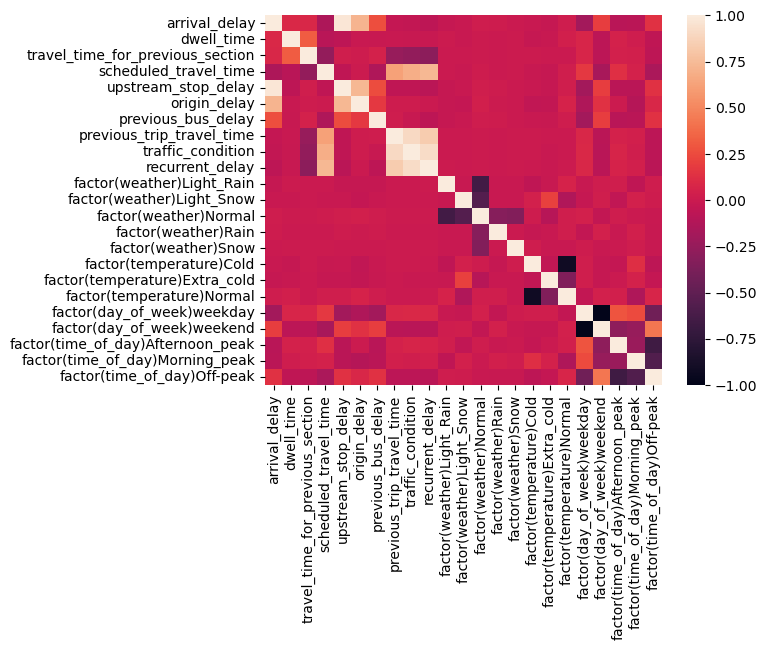

In [7]:
sns.heatmap(df_correlation.corr(), annot=False)

The created correlation matrix and heatmap show that there are several columns correlated with each other. For this research, the most important are the correlations between the arrival_delay and the other columns, because this the target column that we want to predict. We see that the arrival_delay is mainly positively correlated with the upstream_stop_delay (0.975) and with the origin delay (0.716). Furthermore it shows some correlation with the previous bus delay (0.265), the weekday/weekend column (-0.191, 0.191), off-peak factor (0.138), the month (0.129) and the scheduled_travel_time (-0.142).

When looking at the rest of the dataset, we also see strong correlations between the upstream_stop_delay and the origin_delay (0.730). Furthermore we see also correlations between the previous_trip_travel time, the traffic_conditions and the recurrent_delay (0.833-0.918). These last 3 columns are also correlated with the scheduled_travel_time (0.618-0.728).

#### Step 1.1.2: Normality of the arrival_delay feature

In the next cells we will check whether the arrival_delay column is approxiamtely normally distributed. According to Sen, Singh and Chakraborty (2023) this is important for training most machine learning models. First we will look at this graphically with a histogram of the data and a QQ-plot. Lastly we will check the normality numerically with a Kolmogorov-Smirnov test and a Shapiro-Wilk test.  

(array([1.0000e+00, 3.0000e+00, 6.0000e+00, 5.0000e+00, 5.0000e+00,
        4.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 7.0000e+00, 9.0000e+00, 1.7000e+01,
        6.0000e+00, 9.0000e+00, 2.0000e+00, 6.0000e+00, 1.0000e+01,
        8.0000e+00, 2.0000e+00, 5.0000e+00, 1.0000e+01, 1.4000e+01,
        1.0000e+01, 1.2000e+01, 1.3000e+01, 1.4000e+01, 3.0000e+01,
        3.2000e+01, 3.0000e+01, 4.9000e+01, 4.2000e+01, 1.0100e+02,
        3.4300e+02, 1.1300e+03, 3.1780e+03, 1.0593e+04, 3.4299e+04,
        9.2023e+04, 1.0356e+05, 8.5623e+04, 5.9049e+04, 4.3068e+04,
        2.9976e+04, 2.1477e+04, 1.5586e+04, 1.1609e+04, 8.3070e+03,
        6.5310e+03, 4.8500e+03, 3.6730e+03, 2.64

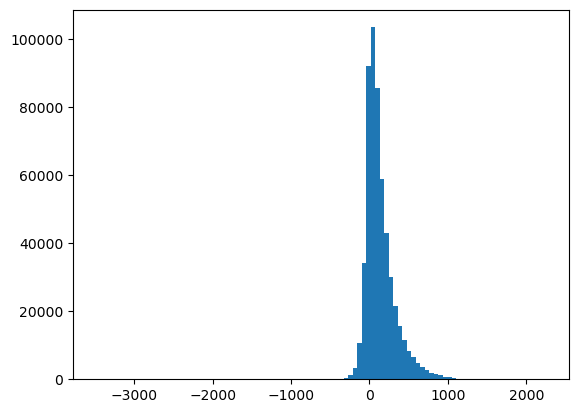

In [8]:
# Distribution of arrival delays (histogram):
plt.hist(df["arrival_delay"], bins=100)

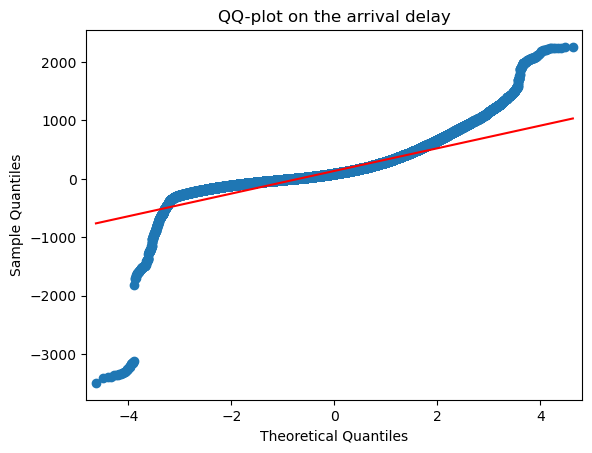

In [9]:
#qq-plot
#Reference: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
qqplot(df["arrival_delay"], line='s')
plt.title("QQ-plot on the arrival delay")
plt.show()

In [10]:
#Kolmogorov-Smirnov test and a Shapiro-Wilk test
#Reference: https://www.statology.org/normality-test-python/
print(kstest(df["arrival_delay"], 'norm'))

print(shapiro(df["arrival_delay"]))

KstestResult(statistic=0.7782036909231179, pvalue=0.0, statistic_location=3, statistic_sign=-1)
ShapiroResult(statistic=0.8616204857826233, pvalue=0.0)


The histogram shows that the data is not fully symmetric (a bit skewed to the right) and does not exactly have the form of the Bell-curve. In the QQ-plot we can see that the data defintitely does not follow a normal distribution. This result is confirmed by both numerical tests, because both tests give a p-value below 0.05. There is a significant difference between the arrival delays and the normal distribution. However, it should be mentioned that both numerical tests are not completely applicable for datasets with a large size as in this assignment (Mishra et al., 2019). However, based on the QQ-plot and histogram will can still conclude that the arrival_delay is probably not normally distributed.

#### Step 1.1.3: Distribution of cases over the dates

At the beginning we have seen with df.info() and with the df.head() statements that the calendar date is an integer value. The calendar date is formatted as YearMonthDay. To be able to make some plots over time in this step, it is useful to have the date in a datetime format. We do this in the next cell. We create a new column with the date in an improved format. With the df.head() statement and df.info() we show that the new column indeed contains the right data format.

In [11]:
df["date"] = pd.to_datetime(df["Calendar_date"], format='%Y%m%d')
df.head(10)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,date
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,0,0,1,0,1,0,0,1,2022-01-08


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 32 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Calendar_date                      545103 non-null  int64         
 1   route_id                           545103 non-null  int64         
 2   bus_id                             545103 non-null  int64         
 3   stop_sequence                      545103 non-null  int64         
 4   arrival_delay                      545103 non-null  int64         
 5   dwell_time                         545103 non-null  int64         
 6   travel_time_for_previous_section   545103 non-null  int64         
 7   scheduled_travel_time              545103 non-null  int64         
 8   upstream_stop_delay                545103 non-null  int64         
 9   origin_delay                       545103 non-null  int64         
 10  previous_bus_delay  

The results shows that we get the date in the right format and with the right datatype (datetime64).

In the next cell we zoom in on the Calendar_date column. We will look at the distribution of the number of measurements over the day. First we create a plot for the full dataset. For this we use the value_counts function for each unique value (dates) in the date column in the dataset. Afterwards we split the data for each month. Based on this, we create similar plots for each month seperately. In these last plots we distinguish between weekdays and weekend. In this way we can explore whether the amount of datapoints are different in the weekends.

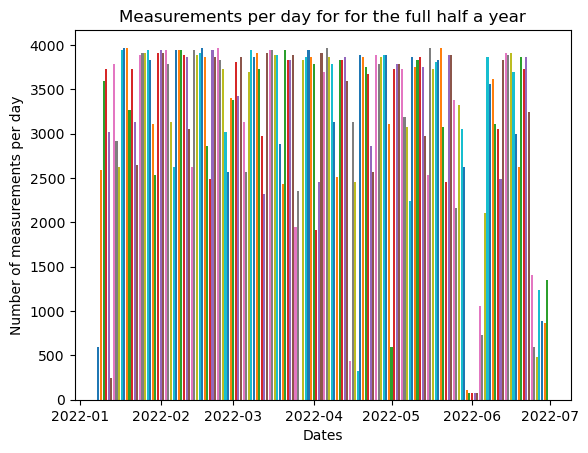

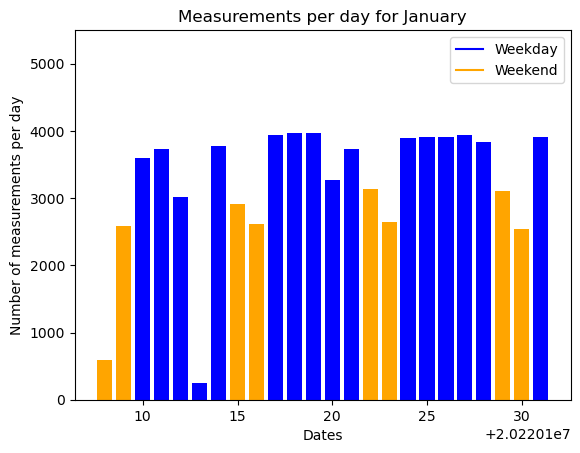

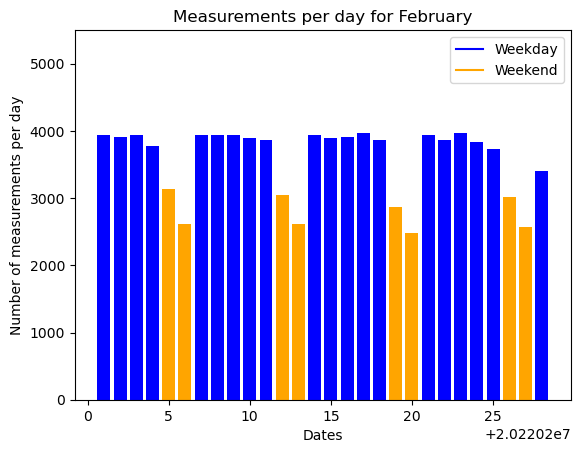

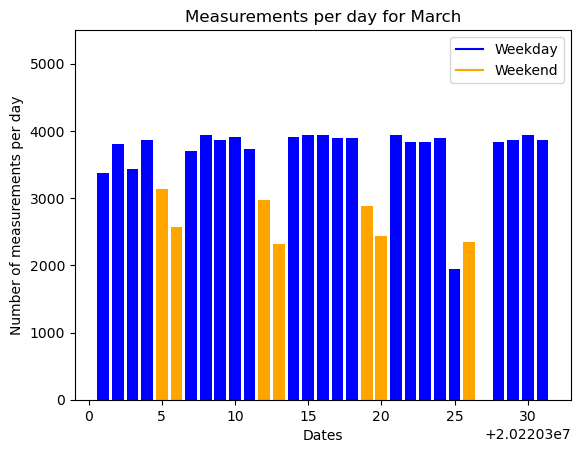

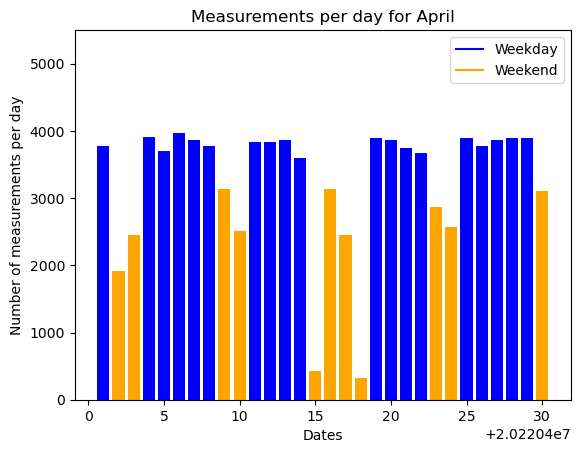

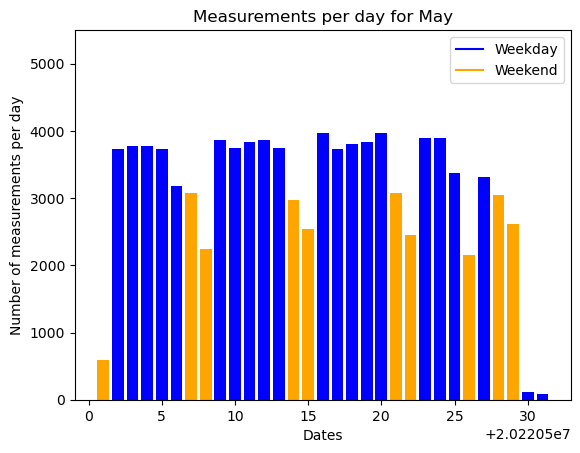

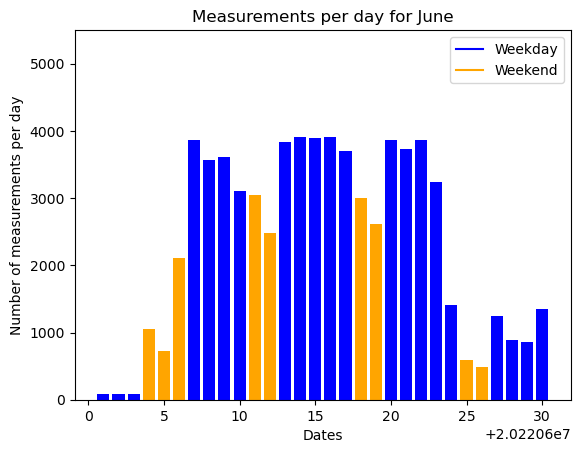

In [13]:
for i in df["date"].unique():
    count = df["date"].value_counts()[i]
    plt.bar(i, count)
    plt.xlabel("Dates")
    plt.ylabel("Number of measurements per day")
    plt.title("Measurements per day for for the full half a year")
plt.show()


# Plot the number of data points per day for each month seperately:
df['month'] = df['date'].dt.month
for i in df["month"].unique():
    df_month = df.loc[df['month'] == i]
    for j in df_month["Calendar_date"].unique():
        week_day_list = df_month.loc[df["Calendar_date"] == j, "day_of_week"]
        week_day = week_day_list[week_day_list.index[0]]
        count = df_month["Calendar_date"].value_counts()[j]
        color_list = ['blue' if (week_day == "weekday") else 'orange']
        plt.bar(j, count, color=color_list)
        plt.ylim(0,5500)
        plt.xlabel("Dates")
        plt.ylabel("Number of measurements per day") 
        
        #Reference for creating the legend: https://stackoverflow.com/questions/11983024/matplotlib-legends-not-working
        blue_bar = mlines.Line2D([], [], color='blue', label='Weekday')
        orange_bar = mlines.Line2D([], [], color='orange', label='Weekend')
        plt.legend(handles=[blue_bar, orange_bar])

        if i == 1:
            plt.title("Measurements per day for January")
        elif i == 2:
            plt.title("Measurements per day for February")
        elif i == 3:
            plt.title("Measurements per day for March")
        elif i == 4:
            plt.title("Measurements per day for April")
        elif i == 5:
            plt.title("Measurements per day for May")
        elif i == 6:
            plt.title("Measurements per day for June")
        else:
            print("Warning: Plot created for undefined month!")    
    plt.show()

When considering the plots created in the previous cell, we clearly see that some days have less data than others. Generally speaking, weekend days have less data than week days, with sunday even less than saturdays. Furthermore we see that public holidays are marked as weekend.

#### Step 1.1.4: Delay at different busstops

In the next cell we will consider the distribution of the busstops in the dataset.

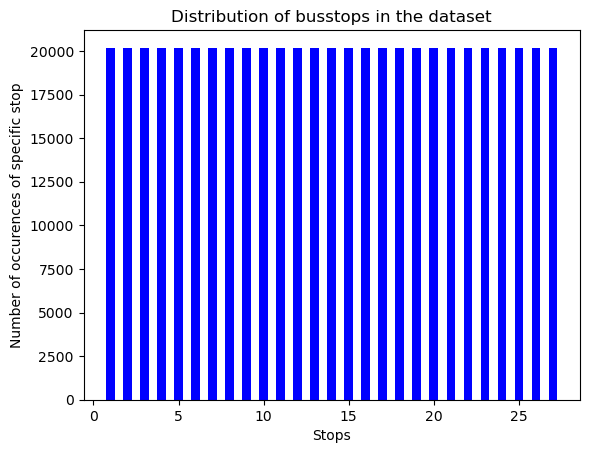

In [14]:
# Distribution of stops:
for i in df["stop_sequence"].unique():
    count = df["stop_sequence"].value_counts()[i]
    plt.bar(i, count, width = 0.5, color="blue")
    plt.xlabel("Stops")
    plt.ylabel("Number of occurences of specific stop")
    plt.title("Distribution of busstops in the dataset")
plt.show()

We see that all stops occur the same number of times. This means that are probably only complete sequences in the dataset.

In the next cell we plot the arrival delay minus the origin delay over the stops. We subtract the origin delay to get a better view on how the arrival delay develops as the buses travel further along the route.

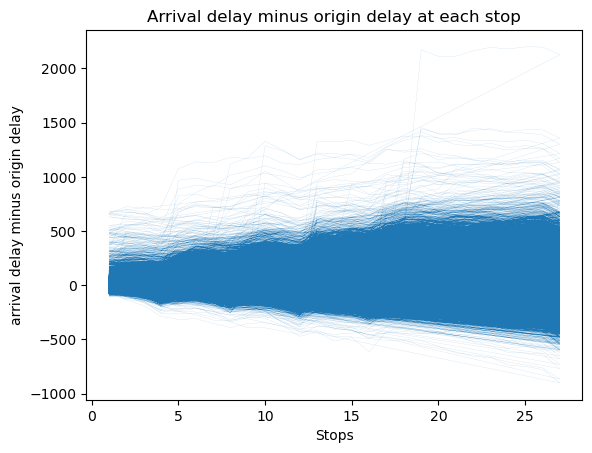

In [15]:
plt.plot(df["stop_sequence"], df["arrival_delay"]-df["origin_delay"], linewidth=0.05)
plt.xlabel("Stops")
plt.ylabel("arrival delay minus origin delay")
plt.title("Arrival delay minus origin delay at each stop")
plt.show()

To have a better look at the behaviour when we would leave outliers, we create the same plot once again with a limit on the Y-axis:

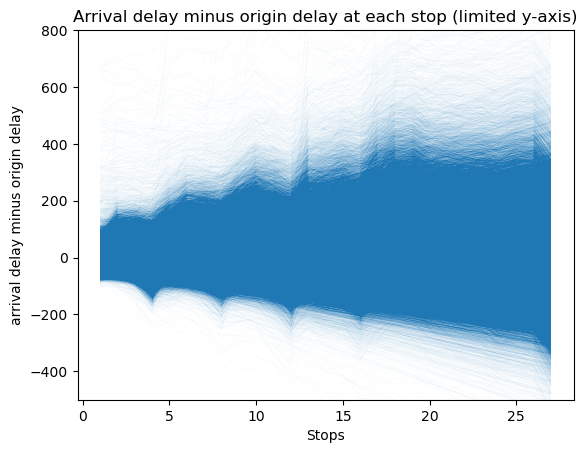

In [16]:
plt.plot(df["stop_sequence"], df["arrival_delay"]-df["origin_delay"], linewidth=0.01)
plt.ylim(-500,800)
plt.xlabel("Stops")
plt.ylabel("arrival delay minus origin delay")
plt.title("Arrival delay minus origin delay at each stop (limited y-axis)")
plt.show()

We see no clear upward or downward trend in the data. However, it is clear that the differences between the busses increases along the route (the variance in arrival_delay-origin_delay increases). In addition, we see a slightly wavy pattern in the graph, which means that some stops relatively often cause additional delays, while others stops seems to lead to a decrease in delay. 

#### Step 1.1.5: Analyzing the object columns

Next up we want to have a better look at the object columns in the dataset (weather, temperature, day_of_week, time_of_day). First we will look at which unique values are in these columns:

In [17]:
print("Objects in weather column: ", df["weather"].unique())
print("Objects in temperature column: ", df["temperature"].unique())
print("Objects in day_of_week column: ", df["day_of_week"].unique())
print("Objects in time_of_day column: ", df["time_of_day"].unique())

Objects in weather column:  ['Light Snow' 'Normal' 'Light Rain' 'Rain' 'Snow']
Objects in temperature column:  ['Normal' 'Cold' 'Extra cold']
Objects in day_of_week column:  ['weekend' 'weekday']
Objects in time_of_day column:  ['OP' 'MP' 'AP']


The found elements in the object columns correspond to the last 13 columns of the dataset. Based on this, we can conclude that one-hot encoding was applied to the 4 object columns.

Next up we visually present the object columns in the dataset, to show the imbalance that we found earlier in section 1.1.1.

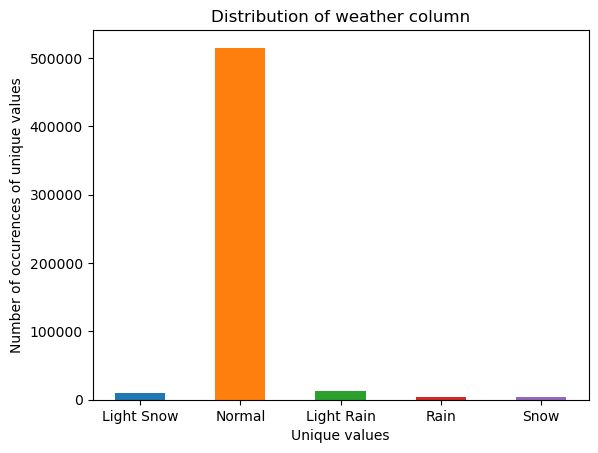

In [18]:
# Distribution of the wheather column:
for i in df["weather"].unique():
    count = df["weather"].value_counts()[i]
    plt.bar(i, count, width = 0.5)
    plt.xlabel("Unique values")
    plt.ylabel("Number of occurences of unique values")
    plt.title("Distribution of weather column")
plt.show()

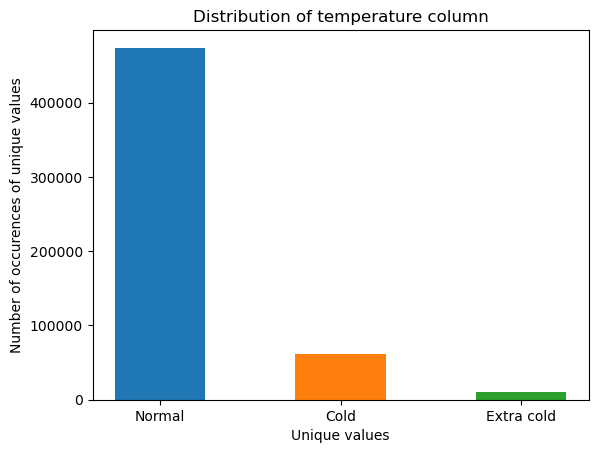

In [19]:
# Distribution of the temperature column:
for i in df["temperature"].unique():
    count = df["temperature"].value_counts()[i]
    plt.bar(i, count, width = 0.5)
    plt.xlabel("Unique values")
    plt.ylabel("Number of occurences of unique values")
    plt.title("Distribution of temperature column")
plt.show()

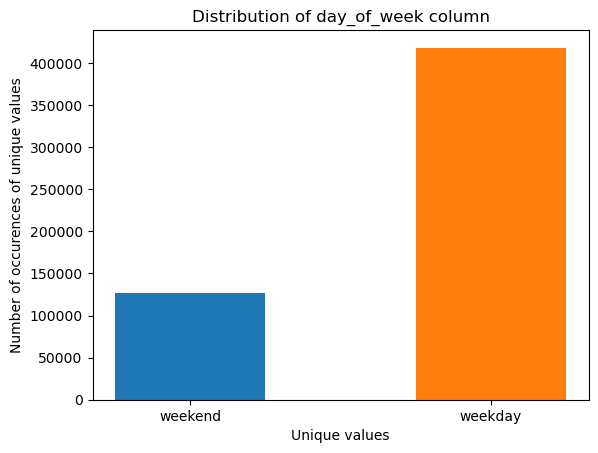

In [20]:
# Distribution of the day_of_week column:
for i in df["day_of_week"].unique():
    count = df["day_of_week"].value_counts()[i]
    plt.bar(i, count, width = 0.5)
    plt.xlabel("Unique values")
    plt.ylabel("Number of occurences of unique values")
    plt.title("Distribution of day_of_week column")
plt.show()

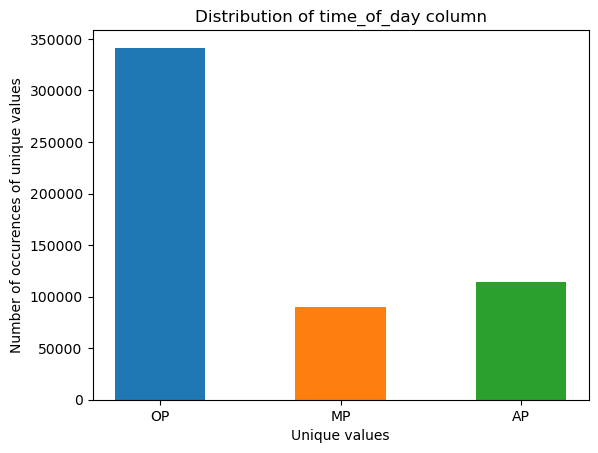

In [21]:
# Distribution of the time_of_day column:
for i in df["time_of_day"].unique():
    count = df["time_of_day"].value_counts()[i]
    plt.bar(i, count, width = 0.5)
    plt.xlabel("Unique values")
    plt.ylabel("Number of occurences of unique values")
    plt.title("Distribution of time_of_day column")
plt.show()

The last 4 plots clearly show that the data is not evenly distributed in the 4 object columns in the data set. We see in the weather column for example that there are much more days with normal weather, than that there rainy or snowy days. We see the same pattern in the temperature column, which contains much more often normal as value than cold or extra cold. In the weekday bar chart we see a pattern that was to be expected, approximately 3 times as many weekdays as there are weekenddays in the dataset. Lastly for the time of day column we have much more OP (off-peak) values than that we have MP (morning peak) or AF (afternoon peak) values.
In conclusion, the object columns, and therefore also the one-hot encoding columns made based on these columns, are fairly imbalanced. 

In the next cells we will look at the difference in distribution in the arrival delay when we group the data by the weather, temperature, day of the week and time of the day respectively.

Text(0.5, 0, 'Weather type')

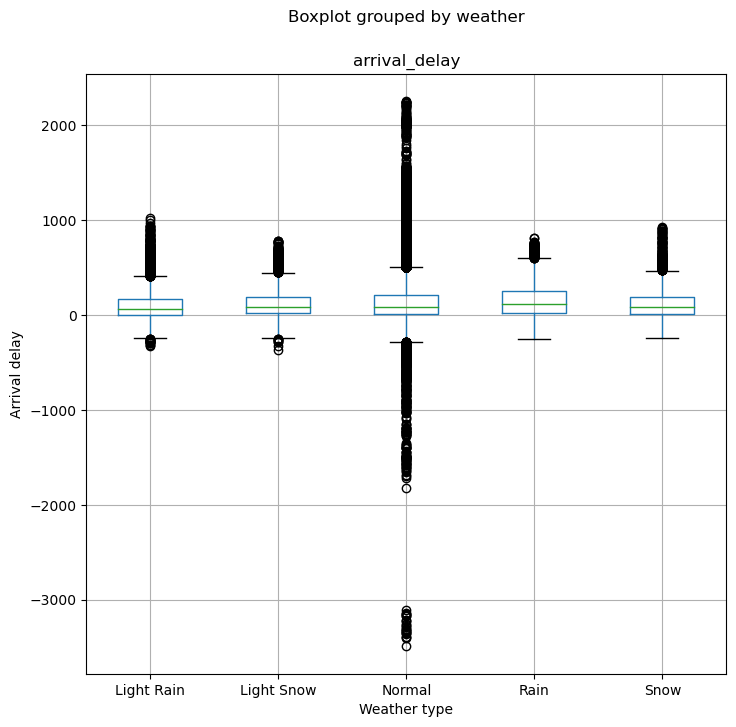

In [22]:
#Arrival delay per weather
boxplots = df.boxplot(column=["arrival_delay"], by=["weather"], figsize=(8,8))
boxplots.set_ylabel("Arrival delay")
boxplots.set_xlabel("Weather type")

Text(0.5, 0, 'Temperature')

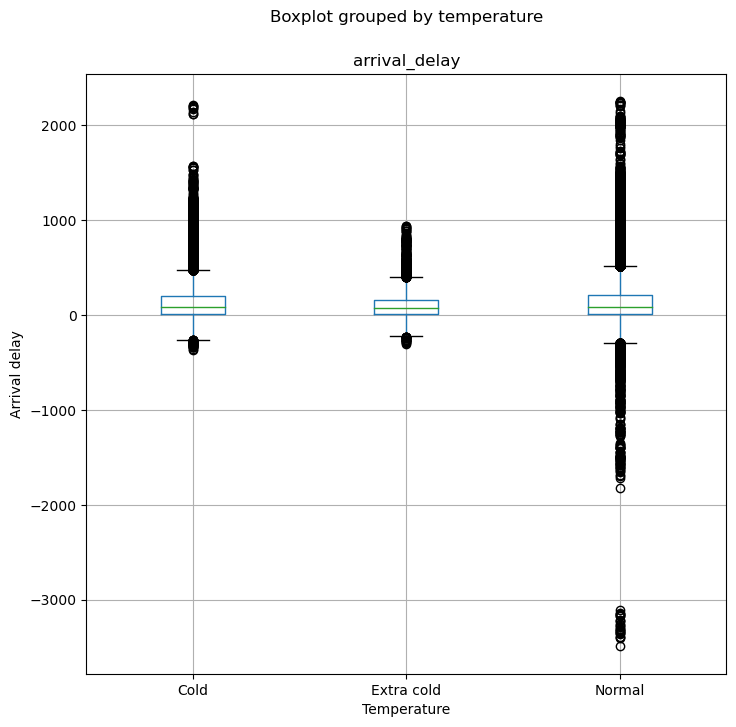

In [23]:
#Arrival delay per temperature type
boxplots = df.boxplot(column=["arrival_delay"], by=["temperature"], figsize=(8,8))
boxplots.set_ylabel("Arrival delay")
boxplots.set_xlabel("Temperature")

Text(0.5, 0, 'Day of the week')

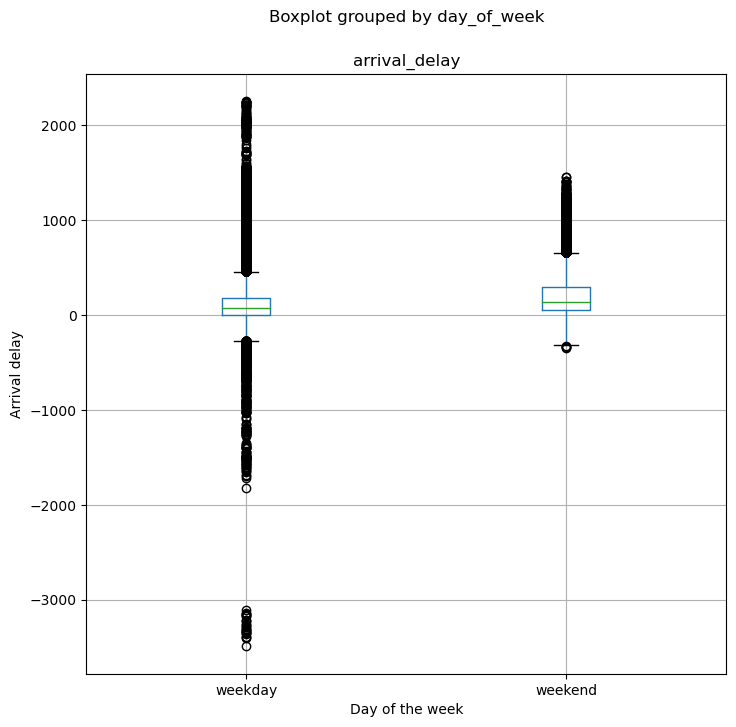

In [24]:
#Arrival delay per day of the week
boxplots = df.boxplot(column=["arrival_delay"], by=["day_of_week"], figsize=(8,8))
boxplots.set_ylabel("Arrival delay")
boxplots.set_xlabel("Day of the week")

Text(0.5, 0, 'Time of the day')

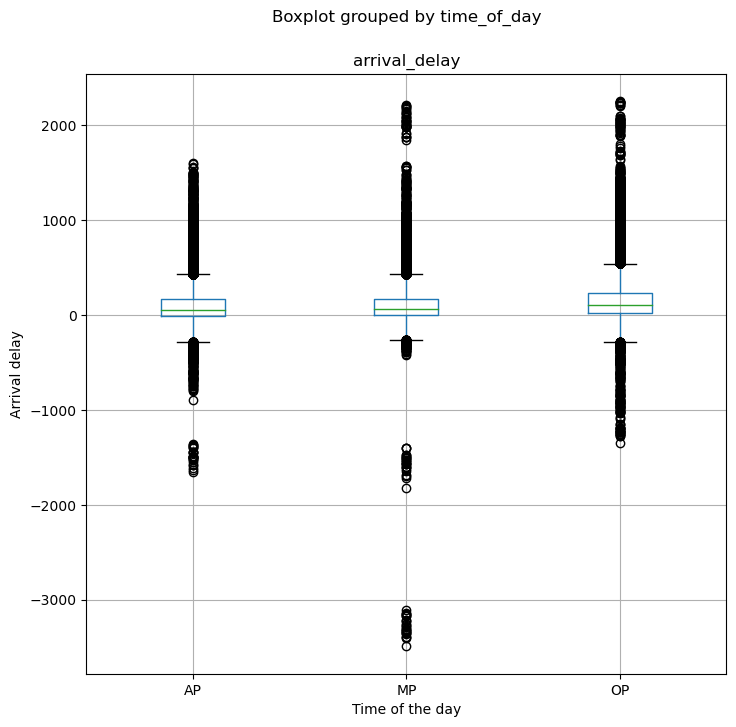

In [25]:
#Arrival delay per time of the day
boxplots = df.boxplot(column=["arrival_delay"], by=["time_of_day"], figsize=(8,8))
boxplots.set_ylabel("Arrival delay")
boxplots.set_xlabel("Time of the day")

From the created boxplots, only the day of the week shows a difference in the distribution of the arrival delays between both categories. In the weekend the distribution of the arrival delays is lightly moved upwards. For the other boxplots, we do not see clear differences in the distribution of the arrival delays for the different categories. Furthermore, in each boxplot we see a high number of outliers (the black dots below and above the whiskers).

#### Step 1.1.6: Analyzing the numerical columns

To have a better look at the bus operation information we create a SNS pairplot with the columns with the highest correlation with the arrival delay. This shows the relations between the columns:

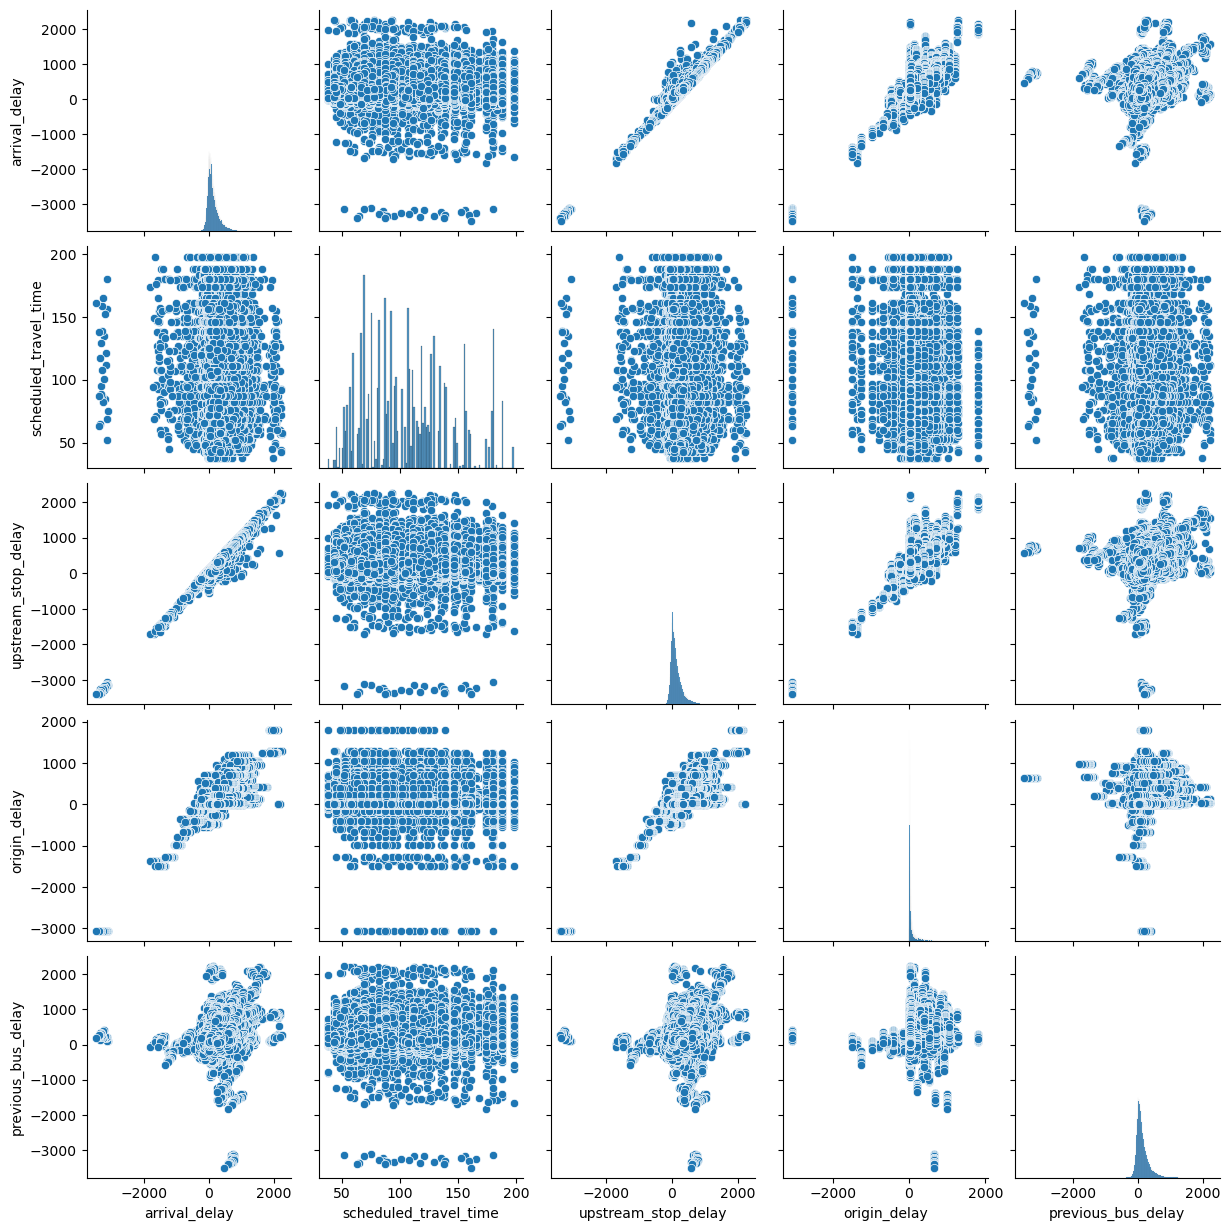

In [26]:
x_pairplot = df[["arrival_delay", "scheduled_travel_time", "upstream_stop_delay", "origin_delay", "previous_bus_delay"]]

sns.pairplot(x_pairplot)

As expected based on the correlation matrix, we see a clear linear relations between the arrival delay and the upstream stop delay. Furthermore, we also see a clear relationship between the arrival delay and the origin delay (although less then the previous). A less clear relationship is vissible between the arrival delay and the previous bus delay. The scheduled travel time does not show a clear relationship with any of the tested other columns. The upstream delay shows approximately the same correlation with the other columns as the arrival delay. This was expected because of the high correlation between both columns.

#### Conclusion section 1.1

In conclusion, mainly the bus operations element columns seem to be important, mainly the upstream stop delay, origin delay and previous delay data. For the object columns the day_of_week (one-hot encoded factor columns) seem to be the most promising. The other object columns do not show a clear correlation with the arrival delay. In the rest of the analysis, we will create a new column with the specific days in it and a new column with the extra delay created between the stop-1 and the stop for which the arrival delay should be predicted for bus j-1. This new column can be interesting, given that the scheduled travel time has less correlation with the arrival delay than we would have expected in advance.

### Step 1.2: Feature engineering

In the previous section we concluded which columns are most useful for training the model. We will try to improve these columns in this section by adding some extra columns based on these, containing new information. First we will extent the information in the day_of_week column by adding a new column with the specific day of the week in it. This is done based on the date column:

In [27]:
df["day"] = df["date"].dt.dayofweek
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Calendar_date                      545103 non-null  int64         
 1   route_id                           545103 non-null  int64         
 2   bus_id                             545103 non-null  int64         
 3   stop_sequence                      545103 non-null  int64         
 4   arrival_delay                      545103 non-null  int64         
 5   dwell_time                         545103 non-null  int64         
 6   travel_time_for_previous_section   545103 non-null  int64         
 7   scheduled_travel_time              545103 non-null  int64         
 8   upstream_stop_delay                545103 non-null  int64         
 9   origin_delay                       545103 non-null  int64         
 10  previous_bus_delay  

In [28]:
df.head(10)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,date,month,day
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,1,0,1,0,0,1,2022-01-08,1,5


The above .head() statement shows that we succesfully added a weekday column to the dataset. In this column monday 0 and goes up to 6 for sunday. 

Furthermore we want to add a column with the trip delay on section stop i-1 to stop i for bus j-1. We can than add this to existing delay of bus j to get a prediction for the arrival delay, to be used in the actual prediction by the ML models. 
For this, we first need to have a unique identifier for each trip (from stop 1 to stop 27) and for each trip per day. With this information we can track which bus was previously at that stop and we can find which bus was the first of that day. This last is important, because the first bus of a day is probably not related to the last bus of the previous day. 
Finally we can calculate the extra delay incurred between stop i-1 and the stop i under investigation for bus j-1 and add this to the upstream delay for bus j to get a prediction for the arrival delay of bus j at stop i. This data will be added in a column to the rows of bus j.

In [29]:
# Unique identifier for each route:
route_ID_list = []
counter = 1
memory_stop = 0

for i in df["stop_sequence"]:
    if memory_stop < i:
        route_ID_list.append(counter)
    elif memory_stop > i:
        counter = counter+1
        route_ID_list.append(counter)
    else:
        print("Warning, previous stop equals current stop, route_ID can not be added to dataset")
        print("Current stop: ", i)
        print("Previous stop: ", memory_test)
        print("Expected stop_ID: ", counter)
    memory_stop=i

df["Route_ID"] = route_ID_list

df.head(1000)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,date,month,day,Route_ID
0,20220108,4,41344,1,151,0,0,120,100,100,...,1,0,1,0,0,1,2022-01-08,1,5,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,1,0,1,0,0,1,2022-01-08,1,5,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,1,0,1,0,0,1,2022-01-08,1,5,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,1,0,1,0,0,1,2022-01-08,1,5,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,1,0,1,0,0,1,2022-01-08,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20220109,4,44418,24,339,12,41,102,350,286,...,0,0,1,0,0,1,2022-01-09,1,6,37
996,20220109,4,44418,25,343,12,79,48,339,286,...,0,0,1,0,0,1,2022-01-09,1,6,37
997,20220109,4,44418,26,340,13,40,66,343,286,...,0,0,1,0,0,1,2022-01-09,1,6,37
998,20220109,4,44418,27,259,0,50,120,340,286,...,0,0,1,0,0,1,2022-01-09,1,6,37


In [30]:
# Unique identifier for each route per day:
# We assume (based on scanning through the CSV file) that the data is ordered over the time axis (first bus first)
route_ID_list_day = []

for j in df["Calendar_date"].unique():
    df_date = df.loc[df["Calendar_date"] == j, ]
    counter_day = 1
    memory_stop_day = 0
    for i in df_date["stop_sequence"]:
        if memory_stop_day < i:
            route_ID_list_day.append(counter_day)
        elif memory_stop_day > i:
            counter_day = counter_day+1
            route_ID_list_day.append(counter_day)
        else:
            print("Warning, previous stop equals current stop, route_ID can not be added to dataset")
            print("Current stop: ", i)
            print("Previous stop: ", memory_stop_day)
            print("Expected stop_ID: ", counter_day)
        memory_stop_day=i
        
df["Route_ID_day"] = route_ID_list_day

df.head(1000)


,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,date,month,day,Route_ID,Route_ID_day
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,1,0,0,1,2022-01-08,1,5,1,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,1,0,0,1,2022-01-08,1,5,1,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,1,0,0,1,2022-01-08,1,5,1,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,1,0,0,1,2022-01-08,1,5,1,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,1,0,0,1,2022-01-08,1,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20220109,4,44418,24,339,12,41,102,350,286,...,0,1,0,0,1,2022-01-09,1,6,37,15
996,20220109,4,44418,25,343,12,79,48,339,286,...,0,1,0,0,1,2022-01-09,1,6,37,15
997,20220109,4,44418,26,340,13,40,66,343,286,...,0,1,0,0,1,2022-01-09,1,6,37,15
998,20220109,4,44418,27,259,0,50,120,340,286,...,0,1,0,0,1,2022-01-09,1,6,37,15


In [31]:
# Calculate extra delay incurred between stop i-1 and stop i for bus j:
df["extra_delay_bus_j"] = df["arrival_delay"] - df["upstream_stop_delay"]
df.head(54)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,date,month,day,Route_ID,Route_ID_day,extra_delay_bus_j
0,20220108,4,41344,1,151,0,0,120,100,100,...,1,0,0,1,2022-01-08,1,5,1,1,51
1,20220108,4,41344,2,185,24,171,45,151,100,...,1,0,0,1,2022-01-08,1,5,1,1,34
2,20220108,4,41344,3,186,0,55,41,185,100,...,1,0,0,1,2022-01-08,1,5,1,1,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,1,0,0,1,2022-01-08,1,5,1,1,16
4,20220108,4,41344,5,242,21,98,86,202,100,...,1,0,0,1,2022-01-08,1,5,1,1,40
5,20220108,4,41344,6,260,13,105,38,242,100,...,1,0,0,1,2022-01-08,1,5,1,1,18
6,20220108,4,41344,7,278,12,43,79,260,100,...,1,0,0,1,2022-01-08,1,5,1,1,18
7,20220108,4,41344,8,272,8,85,97,278,100,...,1,0,0,1,2022-01-08,1,5,1,1,-6
8,20220108,4,41344,9,292,24,83,47,272,100,...,1,0,0,1,2022-01-08,1,5,1,1,20
9,20220108,4,41344,10,351,9,43,85,292,100,...,1,0,0,1,2022-01-08,1,5,1,1,59


In [32]:
# Replace information from bus j-1 to bus j:
#For the first bus of the day we insert 0, because there is no useful bus j-1 in this case.
extra_delay_list = []
for i in df.index:
    if df.loc[i, "Route_ID_day"] == 1:
        extra_delay_list.append(0)
    elif df.loc[i, "Route_ID_day"] > 1:
        extra_delay_list.append(df.loc[i-27, "extra_delay_bus_j"])
    else:
        print("Warning: incorrect Route_ID_day value in DataFrame")

df["extra_delay_bus_j-1"] = extra_delay_list
df.head(54)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,date,month,day,Route_ID,Route_ID_day,extra_delay_bus_j,extra_delay_bus_j-1
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,1,2022-01-08,1,5,1,1,51,0
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,1,2022-01-08,1,5,1,1,34,0
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,1,2022-01-08,1,5,1,1,1,0
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,1,2022-01-08,1,5,1,1,16,0
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,1,2022-01-08,1,5,1,1,40,0
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,0,1,2022-01-08,1,5,1,1,18,0
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,0,1,2022-01-08,1,5,1,1,18,0
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,0,1,2022-01-08,1,5,1,1,-6,0
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,0,1,2022-01-08,1,5,1,1,20,0
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,0,1,2022-01-08,1,5,1,1,59,0


In [33]:
# Add the incurred extra delay up with the upstream delay:
df["delay_prediction"] = df["upstream_stop_delay"]+df["extra_delay_bus_j-1"]
df.head(54)


,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,date,month,day,Route_ID,Route_ID_day,extra_delay_bus_j,extra_delay_bus_j-1,delay_prediction
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,1,2022-01-08,1,5,1,1,51,0,100
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,1,2022-01-08,1,5,1,1,34,0,151
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,1,2022-01-08,1,5,1,1,1,0,185
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,1,2022-01-08,1,5,1,1,16,0,186
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,1,2022-01-08,1,5,1,1,40,0,202
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,1,2022-01-08,1,5,1,1,18,0,242
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,1,2022-01-08,1,5,1,1,18,0,260
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,1,2022-01-08,1,5,1,1,-6,0,278
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,1,2022-01-08,1,5,1,1,20,0,272
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,1,2022-01-08,1,5,1,1,59,0,292


The results of the feature engineering stage are presented in the following cells:

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 39 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Calendar_date                      545103 non-null  int64         
 1   route_id                           545103 non-null  int64         
 2   bus_id                             545103 non-null  int64         
 3   stop_sequence                      545103 non-null  int64         
 4   arrival_delay                      545103 non-null  int64         
 5   dwell_time                         545103 non-null  int64         
 6   travel_time_for_previous_section   545103 non-null  int64         
 7   scheduled_travel_time              545103 non-null  int64         
 8   upstream_stop_delay                545103 non-null  int64         
 9   origin_delay                       545103 non-null  int64         
 10  previous_bus_delay  

In [35]:
df_correlation_features = df[["arrival_delay", "upstream_stop_delay", "origin_delay", "previous_bus_delay", 
                             "scheduled_travel_time", "factor(day_of_week)weekday", "factor(day_of_week)weekend", 
                             "day", "extra_delay_bus_j-1", "delay_prediction"]]
df_correlation_features.corr()

,arrival_delay,upstream_stop_delay,origin_delay,previous_bus_delay,scheduled_travel_time,factor(day_of_week)weekday,factor(day_of_week)weekend,day,extra_delay_bus_j-1,delay_prediction
arrival_delay,1.000000,0.975019,0.716324,0.265434,-0.142228,-0.190783,0.190783,0.167588,0.107514,0.981922
upstream_stop_delay,0.975019,1.000000,0.729940,0.250198,-0.056838,-0.188221,0.188221,0.165791,-0.033828,0.975115
origin_delay,0.716324,0.729940,1.000000,0.169857,0.005330,-0.140618,0.140618,0.123414,0.008985,0.719245
previous_bus_delay,0.265434,0.250198,0.169857,1.000000,-0.136826,-0.189343,0.189343,0.166557,0.192142,0.288471
scheduled_travel_time,-0.142228,-0.056838,0.005330,-0.136826,1.000000,0.165351,-0.165351,-0.125990,-0.383905,-0.141012
factor(day_of_week)weekday,-0.190783,-0.188221,-0.140618,-0.189343,0.165351,1.000000,-1.000000,-0.735540,-0.027788,-0.191113
factor(day_of_week)weekend,0.190783,0.188221,0.140618,0.189343,-0.165351,-1.000000,1.000000,0.735540,0.027788,0.191113
day,0.167588,0.165791,0.123414,0.166557,-0.125990,-0.735540,0.735540,1.000000,0.022360,0.167869
extra_delay_bus_j-1,0.107514,-0.033828,0.008985,0.192142,-0.383905,-0.027788,0.027788,0.022360,1.000000,0.188589
delay_prediction,0.981922,0.975115,0.719245,0.288471,-0.141012,-0.191113,0.191113,0.167869,0.188589,1.000000


<Axes: >

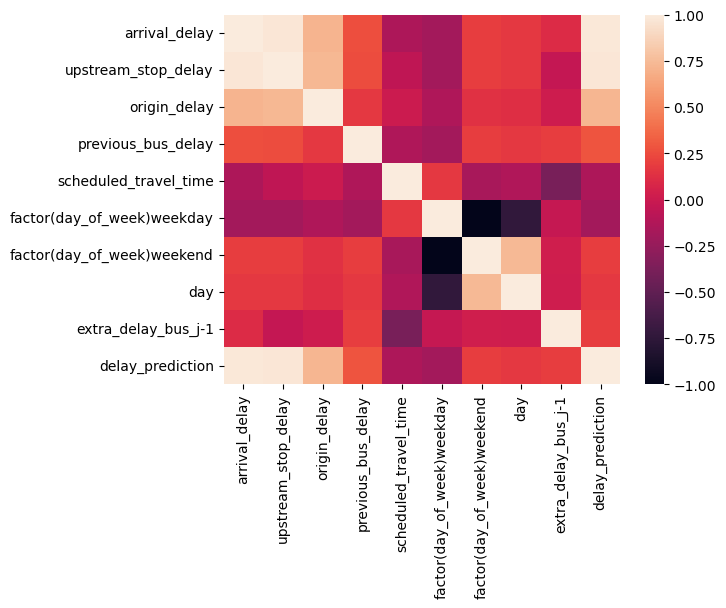

In [36]:
sns.heatmap(df_correlation_features.corr(), annot=False)

### Step 1.3: Data pre-processing

In the data pre-processing step, the data will be made ready for the prediction task in the remainder of this report. We will start with reducing the size of the dataset. First in step 1.3.1 we decrease the number of rows in the dataset, and then in step 1.3.2 we also reduce the number of columns in the dataset. Afterwards we split the reduced datatset in a train and a test part (step 1.3.3). Then continue with deleting the outliers from the training set in step 1.3.4. When this is done we check again the normality for the resulting training set (step 1.3.5). Lastly we will apply normalization to both the training and the test set (step 1.3.6).  

#### Step 1.3.1 Decreasing the number of rows in the dataset

In the next cell we create a smaller dataset with a smaller number of measurements (rows). We have stated the random_state to make sure we get the same dataset every time we re-run the code.

In [37]:
# Create a random subsample of the dataset:
df_subset = df.sample(n=10000, random_state = 1) #Fill-in 545103 for full datatset
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 367404 to 356774
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Calendar_date                      10000 non-null  int64         
 1   route_id                           10000 non-null  int64         
 2   bus_id                             10000 non-null  int64         
 3   stop_sequence                      10000 non-null  int64         
 4   arrival_delay                      10000 non-null  int64         
 5   dwell_time                         10000 non-null  int64         
 6   travel_time_for_previous_section   10000 non-null  int64         
 7   scheduled_travel_time              10000 non-null  int64         
 8   upstream_stop_delay                10000 non-null  int64         
 9   origin_delay                       10000 non-null  int64         
 10  previous_bus_delay          

The above .info() statement shows that the previous code function correctly.

#### Step 1.3.2 Drop less correlated features

In the next cell we drop all the columns that are less correlated with the arrival_delay column (as determined in step 1). The extra columns make the training of the model much more computationaly heavy, resulting in a much longer training time, probably without leading to a much better model. 

In [38]:
df_subset.drop(["Calendar_date", "route_id", "bus_id", "stop_sequence", "dwell_time", 
                "travel_time_for_previous_section", "previous_trip_travel_time", "traffic_condition",
               "recurrent_delay", "weather", "temperature", "day_of_week", "time_of_day", 
               "factor(weather)Light_Rain", "factor(weather)Light_Snow", "factor(weather)Normal",
               "factor(weather)Rain", "factor(weather)Snow", "factor(temperature)Cold",
               "factor(temperature)Extra_cold", "factor(temperature)Normal", "factor(time_of_day)Afternoon_peak",
               "factor(time_of_day)Morning_peak", "factor(time_of_day)Off-peak", "date", "month", "day", "Route_ID",
               "Route_ID_day", "extra_delay_bus_j", "extra_delay_bus_j-1"], axis=1, inplace=True)
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 367404 to 356774
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   arrival_delay               10000 non-null  int64
 1   scheduled_travel_time       10000 non-null  int64
 2   upstream_stop_delay         10000 non-null  int64
 3   origin_delay                10000 non-null  int64
 4   previous_bus_delay          10000 non-null  int64
 5   factor(day_of_week)weekday  10000 non-null  int64
 6   factor(day_of_week)weekend  10000 non-null  int64
 7   delay_prediction            10000 non-null  int64
dtypes: int64(8)
memory usage: 703.1 KB


#### Step 1.3.3 Train-test split

In the next cell we create the train-test split with a test size of 20%. Again the random_state argument is used to make sure we get exactly the same split when re-running the code.

In [39]:
x = df_subset.drop(['arrival_delay'], axis=1)
y = df_subset['arrival_delay']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

#### Step 1.3.4 Delete outliers from the training set

The next step is to delete outliers from the training set. We should delete them both from the arrival delay column and from the other columns. We delete the rows with an arrival delay higher than 875 or lower than -875. We have chosen for this bound because on average busses arrive each 437.5 seconds. This means that busses that arrive more than 2 busses late will be marked as outliers. We do the same for the upstream_stop_delay, origin_delay and previous_bus_delay and delay_prediction.

In [40]:
#Outliers arrival_delay
upper_outlier_index_arrival_delay = y_train[y_train > 875].index
y_train = y_train.drop(upper_outlier_index_arrival_delay)
x_train = x_train.drop(upper_outlier_index_arrival_delay)

lower_outlier_index_arrival_delay = y_train[y_train < -875].index
y_train = y_train.drop(lower_outlier_index_arrival_delay)
x_train = x_train.drop(lower_outlier_index_arrival_delay)

#Outliers upstream_stop_delay
upper_outlier_index_upstream_stop_delay = x_train[x_train["upstream_stop_delay"] > 875].index
y_train = y_train.drop(upper_outlier_index_upstream_stop_delay)
x_train = x_train.drop(upper_outlier_index_upstream_stop_delay)

lower_outlier_index_upstream_stop_delay = x_train[x_train["upstream_stop_delay"] < -875].index
y_train = y_train.drop(lower_outlier_index_upstream_stop_delay)
x_train = x_train.drop(lower_outlier_index_upstream_stop_delay)

#Outliers origin_delay
upper_outlier_index_origin_delay = x_train[x_train["origin_delay"] > 875].index
y_train = y_train.drop(upper_outlier_index_origin_delay)
x_train = x_train.drop(upper_outlier_index_origin_delay)

lower_outlier_index_origin_delay = x_train[x_train["origin_delay"] < -875].index
y_train = y_train.drop(lower_outlier_index_origin_delay)
x_train = x_train.drop(lower_outlier_index_origin_delay)

#Outliers previous_bus_delay
upper_outlier_index_previous_bus_delay = x_train[x_train["previous_bus_delay"] > 875].index
y_train = y_train.drop(upper_outlier_index_previous_bus_delay)
x_train = x_train.drop(upper_outlier_index_previous_bus_delay)

lower_outlier_index_previous_bus_delay = x_train[x_train["previous_bus_delay"] < -875].index
y_train = y_train.drop(lower_outlier_index_previous_bus_delay)
x_train = x_train.drop(lower_outlier_index_previous_bus_delay)

#Outliers delay_prediction
upper_outlier_index_delay_prediction = x_train[x_train["delay_prediction"] > 875].index
y_train = y_train.drop(upper_outlier_index_delay_prediction)
x_train = x_train.drop(upper_outlier_index_delay_prediction)

lower_outlier_index_delay_prediction = x_train[x_train["delay_prediction"] < -875].index
y_train = y_train.drop(lower_outlier_index_delay_prediction)
x_train = x_train.drop(lower_outlier_index_delay_prediction)


print("y_train sumamry statistics: \n", y_train.describe())
print("\nx_train sumamry statistics: \n", x_train.describe())

y_train sumamry statistics: 
 count    7879.000000
mean      123.640056
std       167.885121
min      -650.000000
25%        10.000000
50%        84.000000
75%       199.000000
max       854.000000
Name: arrival_delay, dtype: float64

x_train sumamry statistics: 
        scheduled_travel_time  upstream_stop_delay  origin_delay  \
count            7879.000000          7879.000000   7879.000000   
mean              106.187968           124.541185     68.551339   
std                36.262968           164.256046    112.333981   
min                38.000000          -646.000000   -476.000000   
25%                75.000000            12.000000     14.000000   
50%               104.000000            83.000000     26.000000   
75%               129.000000           198.000000     63.000000   
max               198.000000           875.000000    842.000000   

       previous_bus_delay  factor(day_of_week)weekday  \
count         7879.000000                 7879.000000   
mean           12

When looking at the printed .describe() statements, we see that both the y_train and x_train have the same number of rows, meaning that in both dataframes (y_train is officially a series object) the same amount of observations were deleted. Furthermore we see that indeed the maximum and minimum in the arrival column are now within the defined boundaries.

#### Step 1.3.5. Check the normality of the training set

In the next cell we will again check the normality for the training set. This check is needed to determine whether we should use min-max normalization or z-score normalization in step 1.3.6. We do this check for each numerical column in the training set. 

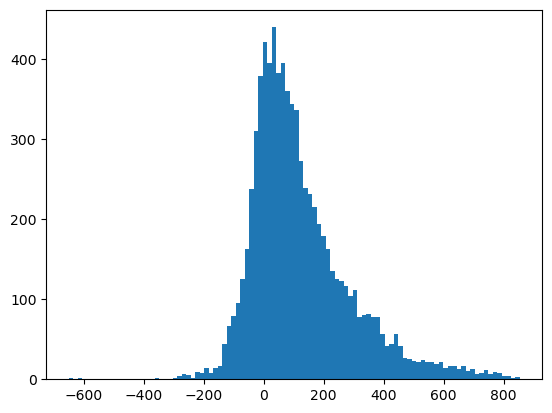

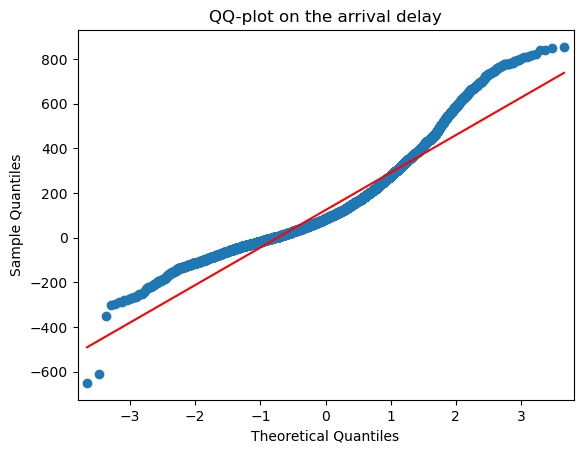

KstestResult(statistic=0.7741292236843237, pvalue=0.0, statistic_location=3, statistic_sign=-1)
ShapiroResult(statistic=0.9180272221565247, pvalue=0.0)


In [41]:
# Distribution of arrival delays (histogram):
plt.hist(y_train, bins=100)

#qq-plot
#Reference: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
qqplot(y_train, line='s')
plt.title("QQ-plot on the arrival delay")
plt.show()

#Kolmogorov-Smirnov test and a Shapiro-Wilk test
#Reference: https://www.statology.org/normality-test-python/
print(kstest(y_train, 'norm'))

print(shapiro(y_train))

The histogram looks the same as before, however more narrower axes. Therefore the histogram still not looks fully symmetrical (slightly skewed to the right). The QQ-plot look better now and better follows the red line. We assume the histogram and QQ-plot look sufficiently like a normal distribution to continue with the next step. Therefore we do not transform the data to let it better resemble a normal distribution.
The Kolmogorov-Smirnov test and Shapiro-Wilk test show that the data is not coming from a normal distribution. However, as stated in Mishra et al. (2019) and in the warning raised by Python, these results may not be accurate for large sample sizes. Therefore we disregard the numerical tests for this data set. 

Now we have a dataset with a target column that we assume to be normally (gaussian) distributed, we can continue with standardization. We will use z-score normalization (standardization) over min-max normalization, because this techniques is better suited for a dataset with features with a widespread. Z-score normalization assumes that the data is normally distributed. Therefore we still have to test this for the other columns besides the arrival_delay and the weekday/weekend columns in the training dataset. Given that the weekday/weekend columns are binary, it cannot be normally distributed. Furthermore, given that it is already on a 0-1 scale, there is also no need to standardize these columns. For the other columns We will check the normality with histograms and QQ-plots for each column in the coming cells:

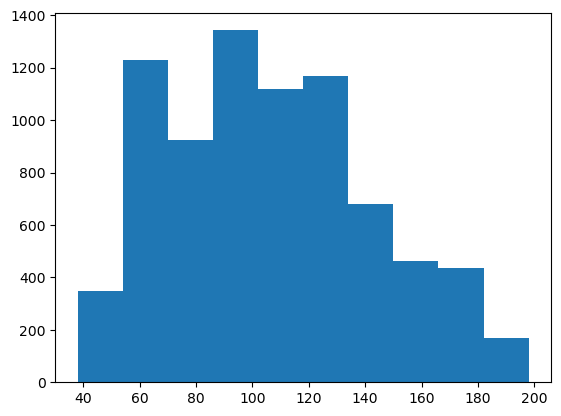

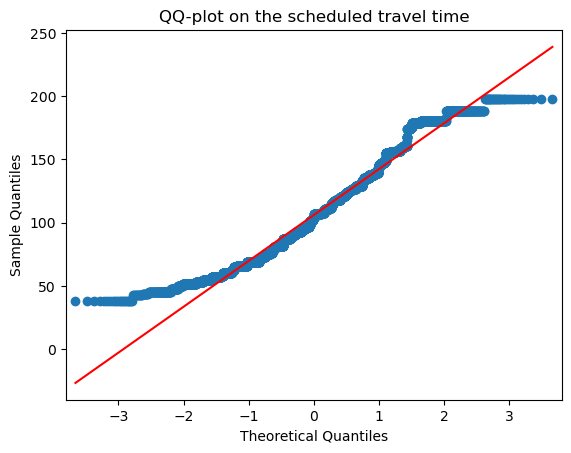

In [42]:
# Normality of scheduled_travel_time:

# Distribution of scheduled travel time (histogram):
plt.hist(x_train["scheduled_travel_time"])

#qq-plot
#Reference: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
qqplot(x_train["scheduled_travel_time"], line='s')
plt.title("QQ-plot on the scheduled travel time")
plt.show()

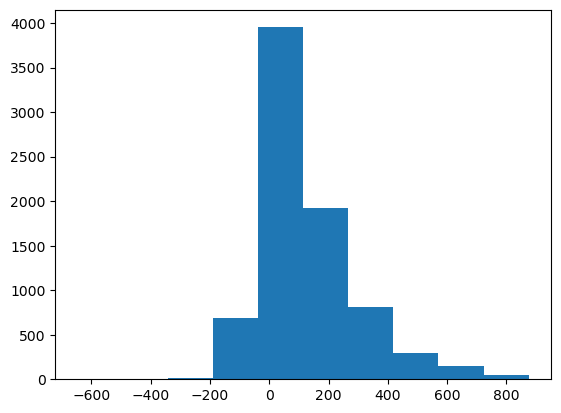

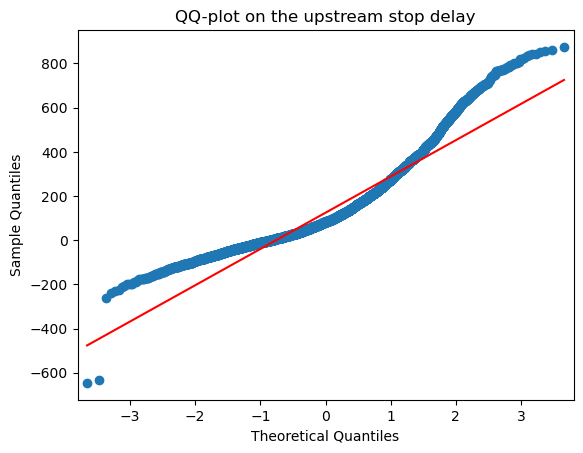

In [43]:
# Normality of upstream_stop_delay:

# Distribution of upstream stop delay (histogram):
plt.hist(x_train["upstream_stop_delay"])

#qq-plot
#Reference: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
qqplot(x_train["upstream_stop_delay"], line='s')
plt.title("QQ-plot on the upstream stop delay")
plt.show()

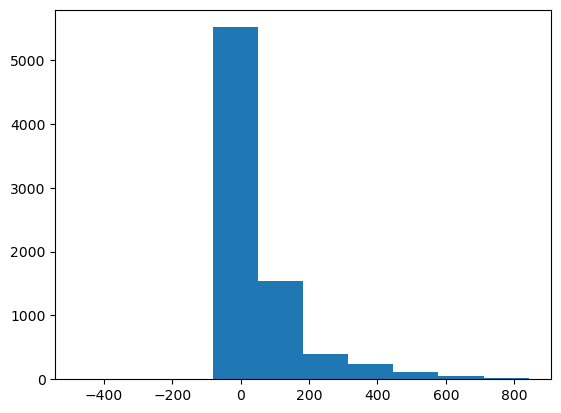

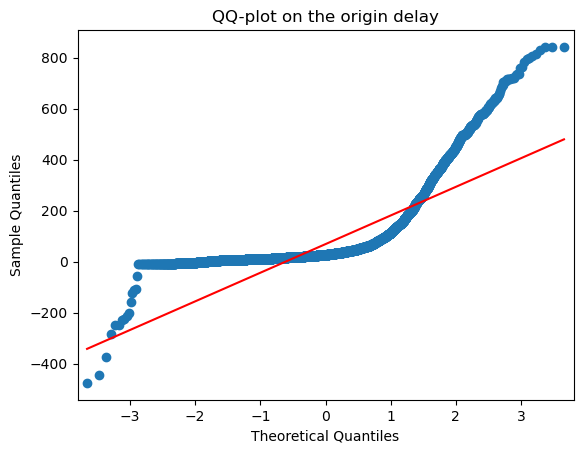

In [44]:
# Normality of origin_delay:

# Distribution of origin delays (histogram):
plt.hist(x_train["origin_delay"])

#qq-plot
#Reference: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
qqplot(x_train["origin_delay"], line='s')
plt.title("QQ-plot on the origin delay")
plt.show()

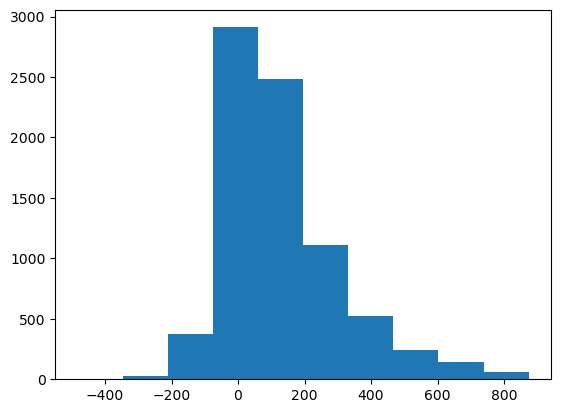

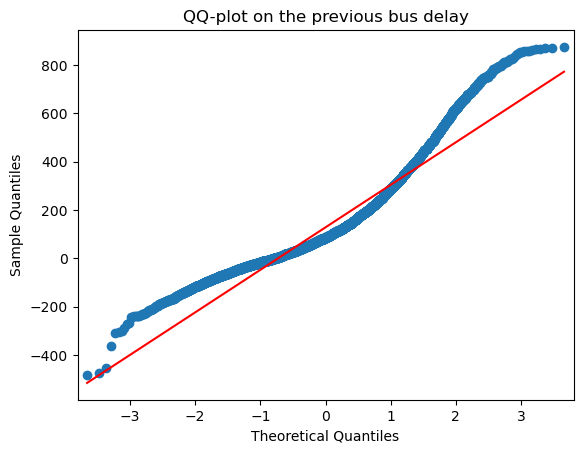

In [45]:
# Normality of previous_bus_delay:

# Distribution of previous bus delays (histogram):
plt.hist(x_train["previous_bus_delay"])

#qq-plot
#Reference: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
qqplot(x_train["previous_bus_delay"], line='s')
plt.title("QQ-plot on the previous bus delay")
plt.show()

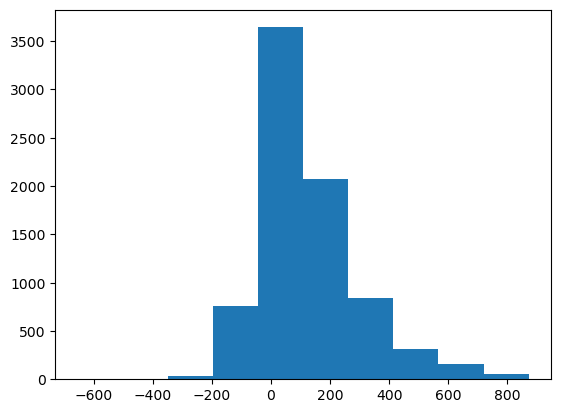

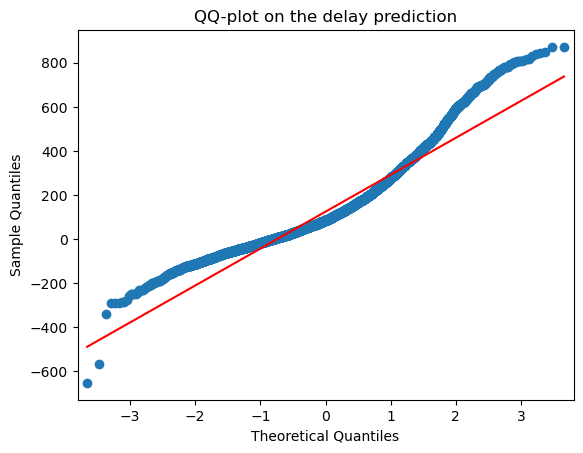

In [46]:
# normality of delay_prediction:

# Distribution of delay prediction (histogram):
plt.hist(x_train["delay_prediction"])

#qq-plot
#Reference: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
qqplot(x_train["delay_prediction"], line='s')
plt.title("QQ-plot on the delay prediction")
plt.show()

For most indpendent variables in the training set we see in the QQ-plots that they are not exactly normally distributed (mainly considering the tales). However, we assume these columns sufficiently resemble a normal distribution to go ahead with the z-score normalization. We use this technique, because we have deleted clear outliers in the training set on which the normalization model is fitted. Therefore we believe that robust scaling in this case is not necessary. 

#### Z-score normalization

In [47]:
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

columns_list = ["scheduled_travel_time", "upstream_stop_delay", "origin_delay", "previous_bus_delay", 
                "delay_prediction", "factor(day_of_week)weekday", "factor(day_of_week)weekend"]
scaler_x = preprocessing.StandardScaler()
scaler_y = preprocessing.StandardScaler()

x_train[columns_list] = scaler_x.fit_transform(x_train[columns_list])
x_test[columns_list] = scaler_x.transform(x_test[columns_list])
y_train = scaler_y.fit_transform(pd.DataFrame(y_train)) 
y_test = scaler_y.transform(pd.DataFrame(y_test))


#print("\n\ndescriptive statistics on x train: \n", np.mean(x_train), np.std(x_train), np.min(x_train), np.max(x_train))
#print("\n\ndescriptive statistics on x test: \n", np.mean(x_test), np.std(x_test), np.min(x_test), np.max(x_test))
#print("\n\ndescriptive statistics on y train: \n", np.mean(y_train), np.std(y_train), np.min(y_train), np.max(y_train))
#print("\n\ndescriptive statistics on y test: \n", np.mean(y_test), np.std(y_test), np.min(y_test), np.max(y_test))

The print statements (commented out to limit the amount output) show that the resulting numpy arrays have as expected a mean of 0 and a standard devation of 1 for the training set. Furthermore we see that minimum and maximum values now lay much closer to eachother. For the test set, from which we did not delete outliers, we see that the mean and standard deviation is close to 0 and 1 respectively. This was expected because the number of outliers in the dataset is relatively limited. For the minimum and maximum we see that those are lower and higher in the test set, because of not removing the outliers.

In the next cell we will create a new x_train and x_test DataFrame without the realtime data column (delay_prediction) in it. This dataset will be used later on to compare the case with real-time data and without.

In [48]:
x_train_not_realtime = x_train.drop("delay_prediction", axis=1) 
x_test_not_realtime = x_test.drop("delay_prediction", axis=1)

### Step 1.4: Exploratory data analysis

In this step we will shortly summarize the resulting data in the training set after the data pre-processing step. We will do this again based on a correlation matrix and summary statistics. 

In [49]:
# Again create a correlation matrix
df_correlation_train = x_train.copy()
df_correlation_train["arrival_delay"] = y_train

df_correlation_train.corr()

,scheduled_travel_time,upstream_stop_delay,origin_delay,previous_bus_delay,factor(day_of_week)weekday,factor(day_of_week)weekend,delay_prediction,arrival_delay
scheduled_travel_time,1.000000,-0.063371,0.012296,-0.154516,0.167550,-0.167550,-0.159612,-0.162095
upstream_stop_delay,-0.063371,1.000000,0.671390,0.218573,-0.175358,0.175358,0.966790,0.967175
origin_delay,0.012296,0.671390,1.000000,0.141385,-0.120470,0.120470,0.658740,0.654300
previous_bus_delay,-0.154516,0.218573,0.141385,1.000000,-0.190056,0.190056,0.266926,0.240446
factor(day_of_week)weekday,0.167550,-0.175358,-0.120470,-0.190056,1.000000,-1.000000,-0.177518,-0.180241
factor(day_of_week)weekend,-0.167550,0.175358,0.120470,0.190056,-1.000000,1.000000,0.177518,0.180241
delay_prediction,-0.159612,0.966790,0.658740,0.266926,-0.177518,0.177518,1.000000,0.976884
arrival_delay,-0.162095,0.967175,0.654300,0.240446,-0.180241,0.180241,0.976884,1.000000


<Axes: >

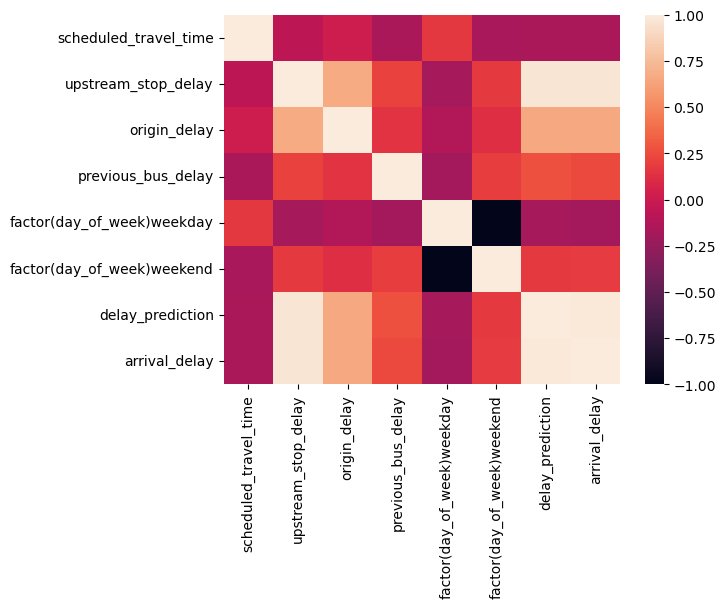

In [50]:
sns.heatmap(df_correlation_train.corr(), annot=False)

In [51]:
df_correlation_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7879 entries, 495901 to 401474
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   scheduled_travel_time       7879 non-null   float64
 1   upstream_stop_delay         7879 non-null   float64
 2   origin_delay                7879 non-null   float64
 3   previous_bus_delay          7879 non-null   float64
 4   factor(day_of_week)weekday  7879 non-null   float64
 5   factor(day_of_week)weekend  7879 non-null   float64
 6   delay_prediction            7879 non-null   float64
 7   arrival_delay               7879 non-null   float64
dtypes: float64(8)
memory usage: 554.0 KB


In [52]:
df_correlation_train.describe()

,scheduled_travel_time,upstream_stop_delay,origin_delay,previous_bus_delay,factor(day_of_week)weekday,factor(day_of_week)weekend,delay_prediction,arrival_delay
count,7.879000e+03,7.879000e+03,7.879000e+03,7.879000e+03,7.879000e+03,7.879000e+03,7.879000e+03,7.879000e+03
mean,-8.477093e-17,1.082182e-17,6.673456e-17,-8.567275e-18,-8.567275e-17,2.074182e-17,-1.803637e-18,2.885819e-17
std,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00
min,-1.880494e+00,-4.691396e+00,-4.847918e+00,-3.470939e+00,-1.864592e+00,-5.363103e-01,-4.635625e+00,-4.608444e+00
25%,-8.601046e-01,-6.852005e-01,-4.856483e-01,-6.783785e-01,5.363103e-01,-5.363103e-01,-6.722930e-01,-6.769347e-01
50%,-6.033998e-02,-2.529211e-01,-3.788172e-01,-2.404413e-01,5.363103e-01,-5.363103e-01,-2.312605e-01,-2.361292e-01
75%,6.291123e-01,4.472498e-01,-4.942130e-02,4.363708e-01,5.363103e-01,-5.363103e-01,4.422079e-01,4.489065e-01
max,2.532001e+00,4.569125e+00,6.885697e+00,4.241306e+00,5.363103e-01,1.864592e+00,4.459179e+00,4.350631e+00


Considering the results in the previous cells, we see that all columns have the same number values and that the correlations are all approximately the same as they were in the descriptive analysis in step 1.1. Furthermore the results show that all columns have a mean of approximately 0 and a standard deviation of 1.

## Step 2: Training the models

### Step 2.1-2.4: 5-fold cross validation, training the models and finding the best parameter combinations

In this section we will try multiple types of regression models. For each model we try, if applicable, multiple combinations of parameters using gridsearch en 5-fold cross-validation. In this way we will try to find the best combination of parameters possible for each method. We will do this for linear regression (2.1.1), decision (regression) trees (2.1.2), random forest (2.1.3), XGBoost (2.1.4), Support Vector Machine (2.1.5) and neural network (2.1.6).

#### Step 2.1.1: Linear regression

A linear regression has no parameters that can be set to improve the results. Therefore a gridsearch is not needed in this case, and we can directly proceed with training the model on te full training set, and testing it on the test set. In the next cell we train the model using the previously created delay_prediction column (step 1.2). Afterwards we will train another linear regression model without this column to see the effect of this column on the quality of the linear regression model.

cross_val_score_linearregression:  [0.9562364  0.96868411 0.96412426 0.962199   0.96690156] 

Mean Absolute Error linear regression: 0.133616255177226
Mean Squared Error linear regression: 0.03400693388507121
R-squared linear regression: 0.9741358808553899

Training and prediction time linear regression: 0:00:00.040977

                      Feature  Coefficients
0       scheduled_travel_time     -0.045482
1         upstream_stop_delay      0.403497
2                origin_delay      0.003262
3          previous_bus_delay     -0.010138
4  factor(day_of_week)weekday     -0.000218
5  factor(day_of_week)weekend      0.000218
6            delay_prediction      0.580008 



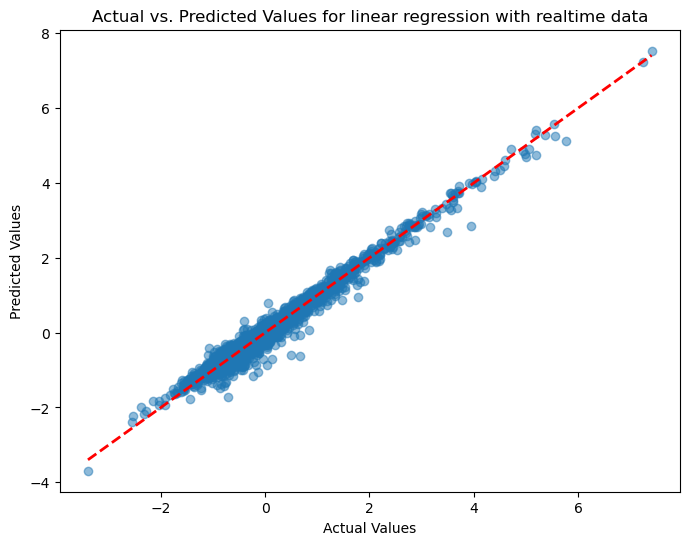

In [53]:
#Linear regression with realtime data:

#Set-up time measurement function:
start_time_linearregression = dt.datetime.now()

#Set up the model and calculate the R-square score for 5-folds:
model_linearregression = LinearRegression()
cross_val_score_linearregression = cross_val_score(model_linearregression, x_train, y_train, cv=5, scoring='r2')
print("cross_val_score_linearregression: ", cross_val_score_linearregression, "\n")

# Fit the model to the training data:
model_linearregression.fit(x_train, y_train)
y_pred_linearregression = model_linearregression.predict(x_test)

#Calculate the performance indicators:
mae_regression = mean_absolute_error(y_test, y_pred_linearregression)
mse_regression = mean_squared_error(y_test, y_pred_linearregression)
r2_regression = r2_score(y_test, y_pred_linearregression)

#Finish time measurement:
end_time_linearregression = dt.datetime.now()
duration_linearregression = end_time_linearregression - start_time_linearregression

#Print final scores on the test set:
print(f"Mean Absolute Error linear regression: {mae_regression}")
print(f"Mean Squared Error linear regression: {mse_regression}")
print(f"R-squared linear regression: {r2_regression}\n")

print(f"Training and prediction time linear regression: {duration_linearregression}\n")

#Reference for getting the coefficients of the trained regression model: 
#https://stackoverflow.com/questions/26951880/scikit-learn-linear-regression-how-to-get-coefficients-respective-features
regression_coefficients = pd.DataFrame({"Feature":x_train.columns, "Coefficients":model_linearregression.coef_[0]})
print(regression_coefficients, "\n")




# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linearregression, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for linear regression with realtime data")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

The linear regression model shows very good results. The MAE and MSE are low. However to really assess these scores, we need to compare it with the MAE and MSE scores of other methods on this dataset. The R-squared score is really close to 1, and therefore very good. The running time is low. When tested for the full training set and tested on the full test set, the code is finished within a second. In the cross validation score (based on r2 measure) we see that it is almost constant for all folds, meaning that it is not sensitive to different parts of data being used for the training. In conclusion, linear regression seems to be a suitable method for predicting the arrival_delay. In the upcoming subsections, we will also fit and compare other models for this task. In the plot we see no strange behaviour for some parts of the data. Therefore we can conclude that this linear regression is overall a good predictor for this dataset.

cross_val_score_linearregression without realtime data:  [0.93403967 0.95079291 0.94516198 0.94597443 0.95257943] 

Mean Absolute Error linear regression without realtime data: 0.16727000594882974
Mean Squared Error linear regression without realtime data: 0.049616026401640284
R-squared linear regression without realtime data: 0.9622643187218507

Training and prediction time linear regression: 0:00:00.040205

                      Feature  Coefficients
0       scheduled_travel_time     -0.101145
1         upstream_stop_delay      0.945505
2                origin_delay      0.019315
3          previous_bus_delay      0.016956
4  factor(day_of_week)weekday      0.004029
5  factor(day_of_week)weekend     -0.004029 



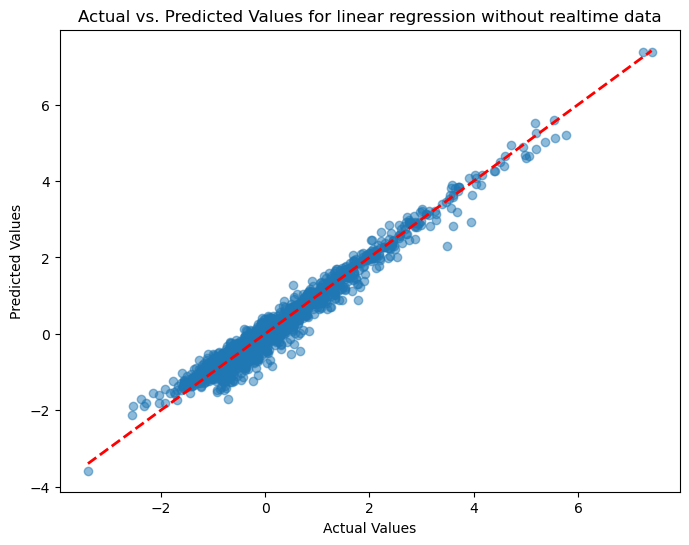

In [54]:
#Linear regression without realtime data:

#Set-up time measurement function:
start_time_linearregression_without = dt.datetime.now()

#Set up the model and calculate the R-square score for 5-folds:
model_linearregression_without = LinearRegression()
cross_val_score_linearregression_without = cross_val_score(model_linearregression_without, 
                                                           x_train_not_realtime, y_train, cv=5, scoring='r2')
print("cross_val_score_linearregression without realtime data: ", cross_val_score_linearregression_without, "\n")

# Fit the model to the training data:
model_linearregression_without.fit(x_train_not_realtime, y_train)
y_pred_linearregression_without = model_linearregression_without.predict(x_test_not_realtime)

#Calculate the performance indicators:
mae_regression_without = mean_absolute_error(y_test, y_pred_linearregression_without)
mse_regression_without = mean_squared_error(y_test, y_pred_linearregression_without)
r2_regression_without = r2_score(y_test, y_pred_linearregression_without)

#Finish time measurement:
end_time_linearregression_without = dt.datetime.now()
duration_linearregression_without = end_time_linearregression_without - start_time_linearregression_without

#Print final scores on the test set:
print(f"Mean Absolute Error linear regression without realtime data: {mae_regression_without}")
print(f"Mean Squared Error linear regression without realtime data: {mse_regression_without}")
print(f"R-squared linear regression without realtime data: {r2_regression_without}\n")

print(f"Training and prediction time linear regression: {duration_linearregression_without}\n")

#Reference for getting the coefficients of the trained regression model: 
#https://stackoverflow.com/questions/26951880/scikit-learn-linear-regression-how-to-get-coefficients-respective-features
regression_coefficients = pd.DataFrame({"Feature":x_train_not_realtime.columns, "Coefficients":model_linearregression_without.coef_[0]})
print(regression_coefficients, "\n")



# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linearregression_without, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for linear regression without realtime data")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

The model without realtime data also shows good results, however, on each performance indicator, the model with realtime data score abit better. The model without realtime data is faster to train, because less data is inserted (1 column less).

When we consider the coefficients of both models, we see that in the first model, the realtime delay_prediction column gets the highest value. In this model also the upstream_stop_delay plays an important role. The other coefficients are much lower, and therefore have less influence on the final prediction of the model. In the linear regression model without the realtime column, we see that the upstream_stop delay becomes even more important. The other columns in the dataset keep there limited role in the model. 

These results were expected, given that the upstream_stop_delay and delay_prediction had by far the highest correlation with the arrival_delay.

In the ordinary least square (OLS) linear regression in the previous cells we found that some of the features get really high coefficients, whereas the other coefficients are nearly zero. This can in some cases result in overfitting the model (Xu, 2019). According to Xu a possible solution for this is using Ridge linear regression instead. This method penalizes high coefficients. In the cells below we will also train a Ridge linear regression model for both the case with and without realtime data.

The most important parameter for the ridge linear regression is the alpha-parameter. This parameter determines the strength of the regularization (alpha=0 gives ordinary least squares regression) (Scikit learn, n.d.). In the next cells we try to find the optimal value for alpha with gridsearch. Afterwards, we train the models with the best alpha parameters on the training set and test it on the test set.

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best Parameters ridge linear regression with realtime data: {'alpha': 15} 

cross_val_score_ridge:  [0.95620832 0.96868461 0.96407621 0.96217953 0.9670307 ] 

Mean Absolute Error ridge regression: 0.1336866705373327
Mean Squared Error ridge regression: 0.03398750930794207
R-squared ridge regression: 0.974150654300679

Training and prediction time ridge regression: 0:00:00.022804

                      Feature  Coefficients
0       scheduled_travel_time     -0.046095
1         upstream_stop_delay      0.408316
2                origin_delay      0.004381
3          previous_bus_delay     -0.009634
4  factor(day_of_week)weekday     -0.000225
5  factor(day_of_week)weekend      0.000225
6            delay_prediction      0.573285 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


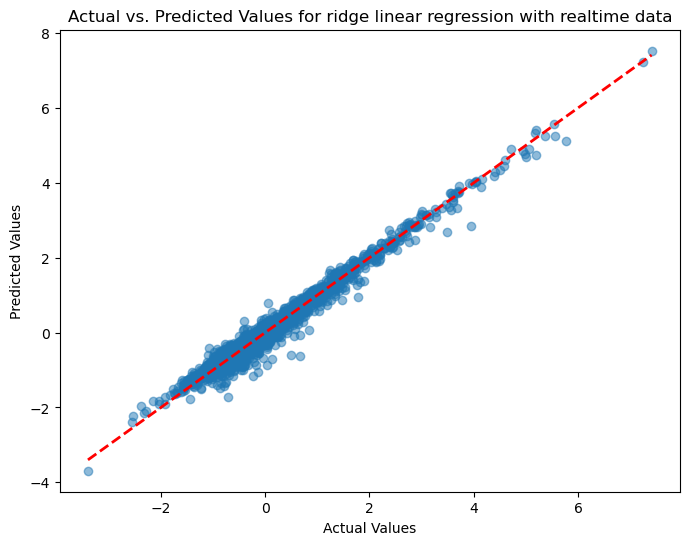

In [55]:
# Ridge linear regression with realtime data:

#Set the potential parameters for the gridsearch
param_grid_ridge = {
    'alpha': [0,1,2,5,8,10,12,15,18,20,25,50,100]
}

# Create the GridSearchCV object
grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5, verbose=1, scoring='r2')

# Fit the grid search to the training data
grid_search_ridge.fit(x_train, y_train)

# Get and print the best parameters
best_params_ridge = grid_search_ridge.best_params_
print("Best Parameters ridge linear regression with realtime data:", best_params_ridge, "\n")

#Set-up time measurement function:
start_time_ridge = dt.datetime.now()

#Set up the model and calculate the R-square score for 5-folds to check the stability of the results:
best_ridge = Ridge(alpha=best_params_ridge['alpha'])
cross_val_score_ridge = cross_val_score(best_ridge, x_train , y_train, cv=5, verbose=1)
print("cross_val_score_ridge: ", cross_val_score_ridge, "\n")

# Fit the model to the training data:
best_ridge.fit(x_train, y_train)
y_pred_ridge = best_ridge.predict(x_test)

#Calculate the performance indicators:
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

#Finish time measurement:
end_time_ridge = dt.datetime.now()
duration_ridge = end_time_ridge - start_time_ridge

#Print final scores on the test set:
print(f"Mean Absolute Error ridge regression: {mae_ridge}")
print(f"Mean Squared Error ridge regression: {mse_ridge}")
print(f"R-squared ridge regression: {r2_ridge}\n")

print(f"Training and prediction time ridge regression: {duration_ridge}\n")

#Reference for getting the coefficients of the trained regression model: 
#https://stackoverflow.com/questions/26951880/scikit-learn-linear-regression-how-to-get-coefficients-respective-features
ridge_coefficients = pd.DataFrame({"Feature":x_train.columns, "Coefficients":best_ridge.coef_[0]})
print(ridge_coefficients, "\n")


# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for ridge linear regression with realtime data")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best Parameters ridge linear regression without realtime data: {'alpha': 2} 

cross_val_score_ridge without realtime data:  [0.93404346 0.95079003 0.94516202 0.9459791  0.9525743 ] 

Mean Absolute Error ridge regression without realtime data: 0.16727531853817923
Mean Squared Error ridge regression without realtime data: 0.04961783909560859
R-squared ridge regression without realtime data: 0.9622629400696932

Training and prediction time ridge regression: 0:00:00.019333

                      Feature  Coefficients
0       scheduled_travel_time     -0.101137
1         upstream_stop_delay      0.945058
2                origin_delay      0.019599
3          previous_bus_delay      0.017004
4  factor(day_of_week)weekday      0.004010
5  factor(day_of_week)weekend     -0.004010 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


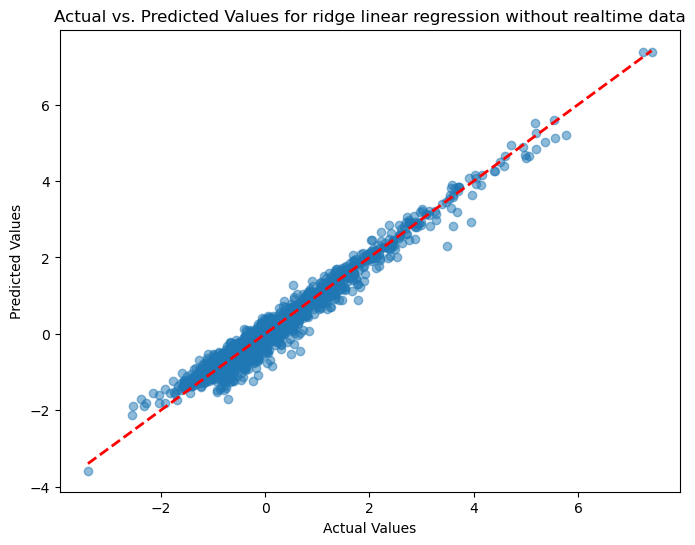

In [56]:
# Ridge linear regression without realtime data:

#Set the potential parameters for the gridsearch
param_grid_ridge_without = {
    'alpha': [0,1,2,5,8,10,12,15,18,20,25,50,100]
}

# Create the GridSearchCV object
grid_search_ridge_without = GridSearchCV(Ridge(), param_grid_ridge_without, cv=5, verbose=1, scoring='r2')

# Fit the grid search to the training data
grid_search_ridge_without.fit(x_train_not_realtime, y_train)

# Get and print the best parameters
best_params_ridge_without = grid_search_ridge_without.best_params_
print("Best Parameters ridge linear regression without realtime data:", best_params_ridge_without, "\n")

#Set-up time measurement function:
start_time_ridge_without = dt.datetime.now()

#Set up the model and calculate the R-square score for 5-folds to check the stability of the results:
best_ridge_without = Ridge(alpha=best_params_ridge_without['alpha'])
cross_val_score_ridge_without = cross_val_score(best_ridge_without, x_train_not_realtime , y_train, cv=5, verbose=1)
print("cross_val_score_ridge without realtime data: ", cross_val_score_ridge_without, "\n")

# Fit the model to the training data:
best_ridge_without.fit(x_train_not_realtime, y_train)
y_pred_ridge_without = best_ridge_without.predict(x_test_not_realtime)

#Calculate the performance indicators:
mae_ridge_without = mean_absolute_error(y_test, y_pred_ridge_without)
mse_ridge_without = mean_squared_error(y_test, y_pred_ridge_without)
r2_ridge_without = r2_score(y_test, y_pred_ridge_without)

#Finish time measurement:
end_time_ridge_without = dt.datetime.now()
duration_ridge_without = end_time_ridge_without - start_time_ridge_without

#Print final scores on the test set:
print(f"Mean Absolute Error ridge regression without realtime data: {mae_ridge_without}")
print(f"Mean Squared Error ridge regression without realtime data: {mse_ridge_without}")
print(f"R-squared ridge regression without realtime data: {r2_ridge_without}\n")

print(f"Training and prediction time ridge regression: {duration_ridge_without}\n")

#Reference for getting the coefficients of the trained regression model: 
#https://stackoverflow.com/questions/26951880/scikit-learn-linear-regression-how-to-get-coefficients-respective-features
ridge_coefficients_without = pd.DataFrame({"Feature":x_train_not_realtime.columns, "Coefficients":best_ridge_without.coef_[0]})
print(ridge_coefficients_without, "\n")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge_without, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for ridge linear regression without realtime data")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()


For the model with the realtime data we get coefficients that are approxiamtely equal to the coefficients from the OLS linear regression. Therefore, the results of the model are also very well comparable. The same holds for the model without the realtime data. 

#### Step 2.1.2: Regression trees

#### Step 2.1.3: Random forest

#### Step 2.1.4: XGBoost

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters XGBoost with realtime data: {'max_depth': 5, 'max_leaves': 2, 'n_estimators': 25} 

cross_val_score_xgboost:  [0.95606249 0.97077901 0.96777715 0.9671458  0.97009473] 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Mean Absolute Error XGBoost: 0.1411406657042603
Mean Squared Error XGBoost: 0.05225845665928163
R-squared XGBoost: 0.9602546070775745

Training and prediction time XGBoost: 0:00:00.230065



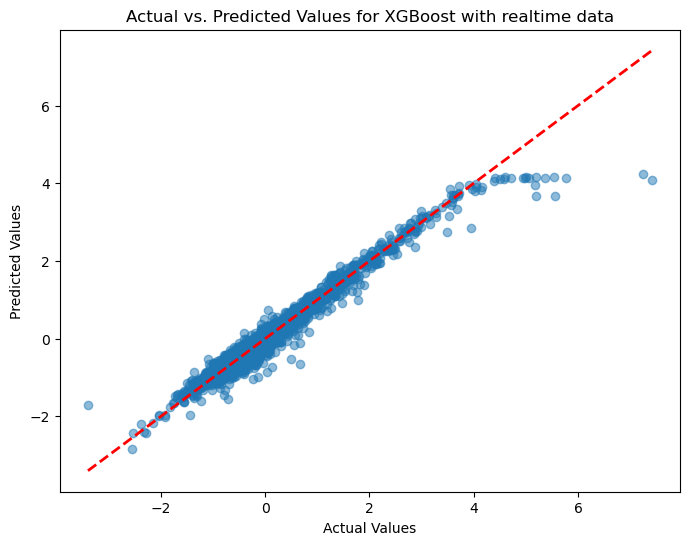

In [63]:
# XGBoost with realtime data:
# References for possible parameters for XGBoost:
#https://xgboost.readthedocs.io/en/stable/parameter.html
#https://medium.com/@rithpansanga/the-main-parameters-in-xgboost-and-their-effects-on-model-performance-4f9833cac7c
    

#Set the potential parameters for the gridsearch
param_grid_xgboost = {
    'n_estimators': [5, 10, 25, 35, 50, 100],
    'max_depth': [2, 5, 10, 50, 100],
    'max_leaves': [2, 5, 10, 50, 100],
    #'eta': [0.2, 0.5, 0.8],
    #'alpha': [0, 1, 5, 10, 50],
    #'lambda': [1, 5, 10, 50]
}


# Create the GridSearchCV object
grid_search_xgboost = GridSearchCV(xgb.XGBRegressor(), param_grid_xgboost, cv=5, verbose=1, scoring='r2')

# Fit the grid search to the training data
grid_search_xgboost.fit(x_train, y_train)

# Get and print the best parameters
best_params_xgboost = grid_search_xgboost.best_params_
print("Best Parameters XGBoost with realtime data:", best_params_xgboost, "\n")

#Set-up time measurement function:
start_time_xgboost = dt.datetime.now()

#Set up the model and calculate the R-square score for 5-folds to check the stability of the results:
best_xgboost = xgb.XGBRegressor(n_estimators=best_params_xgboost['n_estimators'], max_depth=best_params_xgboost['max_depth'], 
                               max_leaves=best_params_xgboost['max_leaves'])
cross_val_score_xgboost = cross_val_score(best_xgboost, x_train , y_train, cv=5, verbose=1)
print("cross_val_score_xgboost: ", cross_val_score_xgboost, "\n")

# Fit the model to the training data:
best_xgboost.fit(x_train, y_train)
y_pred_xgboost = best_xgboost.predict(x_test)

#Calculate the performance indicators:
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
mse_xgboost = mean_squared_error(y_test, y_pred_xgboost)
r2_xgboost = r2_score(y_test, y_pred_xgboost)

#Finish time measurement:
end_time_xgboost = dt.datetime.now()
duration_xgboost = end_time_xgboost - start_time_xgboost

#Print final scores on the test set:
print(f"Mean Absolute Error XGBoost: {mae_xgboost}")
print(f"Mean Squared Error XGBoost: {mse_xgboost}")
print(f"R-squared XGBoost: {r2_xgboost}\n")

print(f"Training and prediction time XGBoost: {duration_xgboost}\n")


# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgboost, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for XGBoost with realtime data")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters XGBoost without realtime data: {'max_depth': 5, 'max_leaves': 2, 'n_estimators': 100} 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


cross_val_score_xgboost_without:  [0.95020464 0.96265303 0.96228709 0.95983335 0.96761975] 

Mean Absolute Error XGBoost without realtime data: 0.14747474589331808
Mean Squared Error XGBoost without realtime data: 0.05381231984938038
R-squared XGBoost without realtime data: 0.9590728097765017

Training and prediction time XGBoost without realtime data: 0:00:00.643490



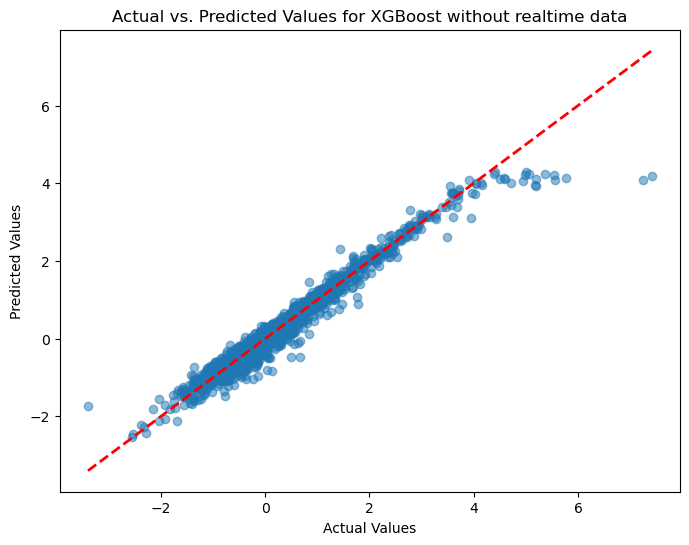

In [64]:
# XGBoost without realtime data:
# References for possible parameters for XGBoost:
#https://xgboost.readthedocs.io/en/stable/parameter.html
#https://medium.com/@rithpansanga/the-main-parameters-in-xgboost-and-their-effects-on-model-performance-4f9833cac7c
    

#Set the potential parameters for the gridsearch
param_grid_xgboost_without = {
    'n_estimators': [5, 10, 25, 35, 50, 100],
    'max_depth': [2, 5, 10, 50, 100],
    'max_leaves': [2, 5, 10, 50, 100],
    #'eta': [0.2, 0.5, 0.8],
    #'alpha': [0, 1, 5, 10, 50],
    #'lambda': [1, 5, 10, 50]
}


# Create the GridSearchCV object
grid_search_xgboost_without = GridSearchCV(xgb.XGBRegressor(), param_grid_xgboost_without, cv=5, verbose=1, scoring='r2')

# Fit the grid search to the training data
grid_search_xgboost_without.fit(x_train_not_realtime, y_train)

# Get and print the best parameters
best_params_xgboost_without = grid_search_xgboost_without.best_params_
print("Best Parameters XGBoost without realtime data:", best_params_xgboost_without, "\n")

#Set-up time measurement function:
start_time_xgboost_without = dt.datetime.now()

#Set up the model and calculate the R-square score for 5-folds to check the stability of the results:
best_xgboost_without = xgb.XGBRegressor(n_estimators=best_params_xgboost_without['n_estimators'], 
                                        max_depth=best_params_xgboost_without['max_depth'], 
                                        max_leaves=best_params_xgboost_without['max_leaves'])
cross_val_score_xgboost_without = cross_val_score(best_xgboost_without, x_train_not_realtime, y_train, cv=5, verbose=1)
print("cross_val_score_xgboost_without: ", cross_val_score_xgboost_without, "\n")

# Fit the model to the training data:
best_xgboost_without.fit(x_train_not_realtime, y_train)
y_pred_xgboost_without = best_xgboost_without.predict(x_test_not_realtime)

#Calculate the performance indicators:
mae_xgboost_without = mean_absolute_error(y_test, y_pred_xgboost_without)
mse_xgboost_without = mean_squared_error(y_test, y_pred_xgboost_without)
r2_xgboost_without = r2_score(y_test, y_pred_xgboost_without)

#Finish time measurement:
end_time_xgboost_without = dt.datetime.now()
duration_xgboost_without = end_time_xgboost_without - start_time_xgboost_without

#Print final scores on the test set:
print(f"Mean Absolute Error XGBoost without realtime data: {mae_xgboost_without}")
print(f"Mean Squared Error XGBoost without realtime data: {mse_xgboost_without}")
print(f"R-squared XGBoost without realtime data: {r2_xgboost_without}\n")

print(f"Training and prediction time XGBoost without realtime data: {duration_xgboost_without}\n")


# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgboost_without, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for XGBoost without realtime data")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

#### Step 2.1.5: Support Vector Machine (SVM)

In [62]:
# Support Vector Machine model with realtime data:

# Set the potential parameters for the gridsearch
# Reference for parameter values for SVM function:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
param_grid_svm = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1, 10]
}

# Create the GridSearchCV object
grid_search_svm = GridSearchCV(SVR(), param_grid_svm, cv=5, verbose=2, scoring='r2')

# Fit the grid search to the training data
grid_search_svm.fit(x_train, y_train)

# Get and print the best parameters
best_params_svm = grid_search_svm.best_params_
print("Best Parameters SVM with realtime data:", best_params_svm, "\n")

# Set-up time measurement function:
start_time_svm = dt.datetime.now()

# Set up the model and calculate the R-square score for 5-folds to check the stability of the results:
best_svm = SVR(kernel=best_params_svm['kernel'], C=best_params_svm['C'], epsilon=best_params_svm['epsilon'])
cross_val_score_svm = cross_val_score(best_svm, x_train , y_train, cv=5, verbose=2)
print("cross_val_score_svm: ", cross_val_score_svm, "\n")

# Fit the model to the training data:
best_svm.fit(x_train, y_train)
y_pred_svm = best_svm.predict(x_test)

# Calculate the performance indicators:
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

# Finish time measurement:
end_time_svm = dt.datetime.now()
duration_svm = end_time_svm - start_time_svm

# Print final scores on the test set:
print(f"Mean Absolute Error SVM: {mae_svm}")
print(f"Mean Squared Error SVM: {mse_svm}")
print(f"R-squared SVM: {r2_svm}\n")

print(f"Training and prediction time svm: {duration_svm}\n")


# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_svm, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for SVM with realtime data")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   1.2s
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   1.1s
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   1.0s
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   1.0s
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   1.0s
[CV] END ..................C=0.01, epsilon=0.01, kernel=poly; total time=   1.4s
[CV] END ..................C=0.01, epsilon=0.01, kernel=poly; total time=   1.2s
[CV] END ..................C=0.01, epsilon=0.01, kernel=poly; total time=   1.1s
[CV] END ..................C=0.01, epsilon=0.01, kernel=poly; total time=   1.2s
[CV] END ..................C=0.01, epsilon=0.01, kernel=poly; total time=   1.2s
[CV] END ...................C=0.01, epsilon=0.01, kernel=rbf; total time=   1.7s
[CV] END ...................C=0.01, epsilon=0.0

[CV] END ..................C=0.1, epsilon=0.1, kernel=linear; total time=   0.6s
[CV] END ..................C=0.1, epsilon=0.1, kernel=linear; total time=   0.7s
[CV] END ..................C=0.1, epsilon=0.1, kernel=linear; total time=   0.7s
[CV] END ..................C=0.1, epsilon=0.1, kernel=linear; total time=   0.7s
[CV] END ....................C=0.1, epsilon=0.1, kernel=poly; total time=   1.2s
[CV] END ....................C=0.1, epsilon=0.1, kernel=poly; total time=   1.1s
[CV] END ....................C=0.1, epsilon=0.1, kernel=poly; total time=   1.4s
[CV] END ....................C=0.1, epsilon=0.1, kernel=poly; total time=   1.3s
[CV] END ....................C=0.1, epsilon=0.1, kernel=poly; total time=   1.5s
[CV] END .....................C=0.1, epsilon=0.1, kernel=rbf; total time=   1.0s
[CV] END .....................C=0.1, epsilon=0.1, kernel=rbf; total time=   1.0s
[CV] END .....................C=0.1, epsilon=0.1, kernel=rbf; total time=   0.9s
[CV] END ...................

KeyboardInterrupt: 

In [ ]:
# Support Vector Machine model with realtime data:

# Set the potential parameters for the gridsearch
# Reference for parameter values for SVM function:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
param_grid_svm_without = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1, 10]
}

# Create the GridSearchCV object
grid_search_svm_without = GridSearchCV(SVR(), param_grid_svm_without, cv=5, verbose=2, scoring='r2')

# Fit the grid search to the training data
grid_search_svm_without.fit(x_train_not_realtime, y_train)

# Get and print the best parameters
best_params_svm_without = grid_search_svm_without.best_params_
print("Best Parameters SVM without realtime data:", best_params_svm_without, "\n")

# Set-up time measurement function:
start_time_svm_without = dt.datetime.now()

# Set up the model and calculate the R-square score for 5-folds to check the stability of the results:
best_svm_without = SVR(kernel=best_params_svm_without['kernel'], C=best_params_svm_without['C'], epsilon=best_params_svm_without['epsilon'])
cross_val_score_svm_without = cross_val_score(best_svm_without, x_train_not_realtime, y_train, cv=5, verbose=2)
print("cross_val_score_svm_without: ", cross_val_score_svm_without, "\n")

# Fit the model to the training data:
best_svm_without.fit(x_train_not_realtime, y_train)
y_pred_svm_without = best_svm_without.predict(x_test_not_realtime)

# Calculate the performance indicators:
mae_svm_without = mean_absolute_error(y_test, y_pred_svm_without)
mse_svm_without = mean_squared_error(y_test, y_pred_svm_without)
r2_svm_without = r2_score(y_test, y_pred_svm_without)

# Finish time measurement:
end_time_svm_without = dt.datetime.now()
duration_svm_without = end_time_svm_without - start_time_svm_without

# Print final scores on the test set:
print(f"Mean Absolute Error SVM: {mae_svm_without}")
print(f"Mean Squared Error SVM: {mse_svm_without}")
print(f"R-squared SVM: {r2_svm_without}\n")

print(f"Training and prediction time svm: {duration_svm_without}\n")


# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_svm_without, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for SVM without realtime data")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

#### 2.1.6: Neural network

### Step 2.4: Train the models on the full training set

## Step 3: Testing the models

### Step 3.1: Make predictions with the models

### Step 3.2: Evaluate model performance

### Step 3.3: Select best model

## Step 4: Final model

### Step 4.1: Train the final model

### Step 4.2: Save the final model

## 5: References

Mishra, P., Pandey, C.M., Singh, U., Gupta, A., Sahu, C., & Keshri, A. (2019). Descriptive statistics and normality tests for statistical data. Annals of cardiac anaesthesia, 22, 67-72. https://doi.org/10.4103/aca.ACA_157_18

Scikit Learn. (n.d.). sklearn.linear_model.Ridge. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

Sen, S., Singh, K.P., Chakraborty, P. (2023). Dealing with imbalanced regression problem for large dataset using scalable artificial neural network. New astronomy, 99. https://doi.org/10.1016/j.newast.2022.101959

Xu, W. (2019, august 22). What's the difference between linear regression, lasso, ridge and elastocNet in Sklearn?. Towards datascience. https://towardsdatascience.com/whats-the-difference-between-linear-regression-lasso-ridge-and-elasticnet-8f997c60cf29
